In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

C:\Users\User\AppData\Local\Temp\ipykernel_712244\543198463.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  specific_humidity      slp  wet_bulb_temperature  temperatures  \
0       6678              12.82  1016.20                 18.08         20.84   
1       6678              12.33  1017.48                 17.71         20.69   
2       6678              12.14  1018.26                 17.29         20.47   
3       6678              11.90  1018.41                 17.20         20.30   
4       6678              12.75  1017.92                 17.75         20.46   
..       ...                ...      ...                   ...           ...   
643     8000               5.15  1016.94                  7.64         13.02   
644     8000               5.24  1016.16                  7.88         13.47   
645     8000               5.36  1017.90                  7.13         11.84   
646     8000               5.43  1016.17                  7.66         12.86   
647     8000               5.32  1015.12                  8.11         13.58   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-08 06:20:10,923] A new study created in memory with name: no-name-e3860cd8-c688-447a-942b-6833eb11cac1
[I 2025-06-08 06:24:45,546] Trial 0 finished with value: 2.131940793991089 and parameters: {'lr': 0.07175395801749809, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16813208973493304}. Best is trial 0 with value: 2.131940793991089.


Cross Validation Accuracies:
[2.2604150772094727, 1.8893342018127441, 1.755995750427246, 2.4152612686157227, 2.338697671890259]
Mean Cross Validation Accuracy:
2.131940793991089
Standard Deviation of Cross Validation Accuracy:
0.2606596147074674


[I 2025-06-08 06:29:12,147] Trial 1 finished with value: 0.08374931886792183 and parameters: {'lr': 0.012857105072758458, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.43312658407979365}. Best is trial 1 with value: 0.08374931886792183.


Cross Validation Accuracies:
[0.06571373343467712, 0.13086415827274323, 0.07930685579776764, 0.09440582990646362, 0.048456016927957535]
Mean Cross Validation Accuracy:
0.08374931886792183
Standard Deviation of Cross Validation Accuracy:
0.028014297426605987


[I 2025-06-08 06:34:35,908] Trial 2 finished with value: 0.07641705721616746 and parameters: {'lr': 0.024721435617986447, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3936617139996025}. Best is trial 2 with value: 0.07641705721616746.


Cross Validation Accuracies:
[0.059328701347112656, 0.09791494160890579, 0.07328737527132034, 0.09294560551643372, 0.05860866233706474]
Mean Cross Validation Accuracy:
0.07641705721616746
Standard Deviation of Cross Validation Accuracy:
0.016457810825448144


[I 2025-06-08 06:39:52,812] Trial 3 finished with value: 0.08522959053516388 and parameters: {'lr': 0.019002788405266733, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.46571284528024504}. Best is trial 2 with value: 0.07641705721616746.


Cross Validation Accuracies:
[0.04962925612926483, 0.11561001092195511, 0.07870296388864517, 0.0944005697965622, 0.08780515193939209]
Mean Cross Validation Accuracy:
0.08522959053516388
Standard Deviation of Cross Validation Accuracy:
0.021557787387545112


[I 2025-06-08 06:44:19,122] Trial 4 finished with value: 0.07631494700908661 and parameters: {'lr': 0.002693731781751435, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1392236292764146}. Best is trial 4 with value: 0.07631494700908661.


Cross Validation Accuracies:
[0.05957384034991264, 0.09716024994850159, 0.07255549728870392, 0.0943811759352684, 0.057903971523046494]
Mean Cross Validation Accuracy:
0.07631494700908661
Standard Deviation of Cross Validation Accuracy:
0.01669896652473251


[I 2025-06-08 06:48:52,566] Trial 5 finished with value: 0.07651191279292106 and parameters: {'lr': 0.00845211838582909, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3286184627431632}. Best is trial 4 with value: 0.07631494700908661.


Cross Validation Accuracies:
[0.06139559671282768, 0.09769497811794281, 0.07255113124847412, 0.09349068999290466, 0.057427167892456055]
Mean Cross Validation Accuracy:
0.07651191279292106
Standard Deviation of Cross Validation Accuracy:
0.01640377652836546


[I 2025-06-08 06:53:54,461] Trial 6 finished with value: 0.1382913589477539 and parameters: {'lr': 0.012465623259720178, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2613563961914498}. Best is trial 4 with value: 0.07631494700908661.


Cross Validation Accuracies:
[0.059154875576496124, 0.12918433547019958, 0.08692958205938339, 0.3422218859195709, 0.0739661157131195]
Mean Cross Validation Accuracy:
0.1382913589477539
Standard Deviation of Cross Validation Accuracy:
0.1046030111902317


[I 2025-06-08 06:59:39,668] Trial 7 finished with value: 0.10106031596660614 and parameters: {'lr': 0.7731548920237837, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.17480077633239122}. Best is trial 4 with value: 0.07631494700908661.


Cross Validation Accuracies:
[0.10074760019779205, 0.11905869841575623, 0.09893368929624557, 0.09322776645421982, 0.09333382546901703]
Mean Cross Validation Accuracy:
0.10106031596660614
Standard Deviation of Cross Validation Accuracy:
0.009482716806974104


[I 2025-06-08 07:05:08,847] Trial 8 finished with value: 0.0761461891233921 and parameters: {'lr': 0.06619042428888852, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11632524721570268}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.05940432846546173, 0.0973341315984726, 0.07220780104398727, 0.09346137940883636, 0.05832330510020256]
Mean Cross Validation Accuracy:
0.0761461891233921
Standard Deviation of Cross Validation Accuracy:
0.016505760902218856


[I 2025-06-08 07:09:38,230] Trial 9 finished with value: 0.07857328951358795 and parameters: {'lr': 0.0023429024277055164, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.49740163662362913}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.05841837823390961, 0.09804387390613556, 0.07327589392662048, 0.09333204478025436, 0.06979625672101974]
Mean Cross Validation Accuracy:
0.07857328951358795
Standard Deviation of Cross Validation Accuracy:
0.014887872023543308


[I 2025-06-08 07:14:27,361] Trial 10 finished with value: 0.10307964533567429 and parameters: {'lr': 0.15013006510161725, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.25856714428515903}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.11363755166530609, 0.09498549997806549, 0.09345587342977524, 0.14272765815258026, 0.07059164345264435]
Mean Cross Validation Accuracy:
0.10307964533567429
Standard Deviation of Cross Validation Accuracy:
0.02407088177659243


[I 2025-06-08 07:19:23,751] Trial 11 finished with value: 0.384370231628418 and parameters: {'lr': 0.0015546723281483709, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10751575352256743}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.3418827950954437, 0.35140588879585266, 0.33442917466163635, 0.5335349440574646, 0.3605983555316925]
Mean Cross Validation Accuracy:
0.384370231628418
Standard Deviation of Cross Validation Accuracy:
0.0751014685071923


[I 2025-06-08 07:24:23,089] Trial 12 finished with value: 0.15891628265380858 and parameters: {'lr': 0.1737813627316175, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11451971806086411}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.14895212650299072, 0.15044575929641724, 0.18831419944763184, 0.19666914641857147, 0.1102001816034317]
Mean Cross Validation Accuracy:
0.15891628265380858
Standard Deviation of Cross Validation Accuracy:
0.031092793086353075


[I 2025-06-08 07:29:00,553] Trial 13 finished with value: 0.22947825789451598 and parameters: {'lr': 0.0049871489272111345, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1960660541726264}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.1916014850139618, 0.1878374069929123, 0.20968660712242126, 0.3659767806529999, 0.19228900969028473]
Mean Cross Validation Accuracy:
0.22947825789451598
Standard Deviation of Cross Validation Accuracy:
0.0686661586593913


[I 2025-06-08 07:33:53,232] Trial 14 finished with value: 0.20206783711910248 and parameters: {'lr': 0.06177037571127324, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2112624775149769}. Best is trial 8 with value: 0.0761461891233921.


Cross Validation Accuracies:
[0.15173065662384033, 0.22149798274040222, 0.1544148325920105, 0.25751993060112, 0.22517578303813934]
Mean Cross Validation Accuracy:
0.20206783711910248
Standard Deviation of Cross Validation Accuracy:
0.04193109341687169


[I 2025-06-08 07:38:43,987] Trial 15 finished with value: 0.06946715041995048 and parameters: {'lr': 0.001003509572168431, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13700828044399488}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.054931484162807465, 0.09548778831958771, 0.07209783792495728, 0.08487727493047714, 0.039941366761922836]
Mean Cross Validation Accuracy:
0.06946715041995048
Standard Deviation of Cross Validation Accuracy:
0.020022604950618535


[I 2025-06-08 07:43:52,065] Trial 16 finished with value: 0.07733862921595573 and parameters: {'lr': 0.5912068091009641, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3221503352198325}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0600394606590271, 0.09736350923776627, 0.07372724264860153, 0.09688660502433777, 0.058676328510046005]
Mean Cross Validation Accuracy:
0.07733862921595573
Standard Deviation of Cross Validation Accuracy:
0.01699237471003208


[I 2025-06-08 07:49:52,333] Trial 17 finished with value: 0.07604728117585183 and parameters: {'lr': 0.052057353553072144, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2355609710897128}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05895096808671951, 0.09659842401742935, 0.07209648936986923, 0.09443242102861404, 0.05815810337662697]
Mean Cross Validation Accuracy:
0.07604728117585183
Standard Deviation of Cross Validation Accuracy:
0.016663002124279312


[I 2025-06-08 07:55:12,980] Trial 18 finished with value: 0.07574717923998833 and parameters: {'lr': 0.2736792957197577, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2411075440998882}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.059786707162857056, 0.09799699485301971, 0.07161477208137512, 0.09217564761638641, 0.05716177448630333]
Mean Cross Validation Accuracy:
0.07574717923998833
Standard Deviation of Cross Validation Accuracy:
0.016626362174065313


[I 2025-06-08 08:00:57,611] Trial 19 finished with value: 0.07566017508506775 and parameters: {'lr': 0.2899976141441963, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2896887149078686}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.059533607214689255, 0.0974680706858635, 0.07078488916158676, 0.09326442331075668, 0.05724988505244255]
Mean Cross Validation Accuracy:
0.07566017508506775
Standard Deviation of Cross Validation Accuracy:
0.016782534071622633


[I 2025-06-08 08:06:37,618] Trial 20 finished with value: 0.07742649242281914 and parameters: {'lr': 0.43821952977057405, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3961011757238669}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06599986553192139, 0.09703172743320465, 0.0725463479757309, 0.09434112161397934, 0.057213399559259415]
Mean Cross Validation Accuracy:
0.07742649242281914
Standard Deviation of Cross Validation Accuracy:
0.015706194036277647


[I 2025-06-08 08:12:20,955] Trial 21 finished with value: 0.07573331892490387 and parameters: {'lr': 0.31704595048473566, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3032386913446151}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.059244606643915176, 0.09693180024623871, 0.07172787189483643, 0.09315720945596695, 0.05760510638356209]
Mean Cross Validation Accuracy:
0.07573331892490387
Standard Deviation of Cross Validation Accuracy:
0.016550050755870307


[I 2025-06-08 08:17:37,964] Trial 22 finished with value: 0.07673674374818802 and parameters: {'lr': 0.14369881995794673, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2931434031616377}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05863100662827492, 0.09706360101699829, 0.07424021512269974, 0.09576848894357681, 0.057980407029390335]
Mean Cross Validation Accuracy:
0.07673674374818802
Standard Deviation of Cross Validation Accuracy:
0.017095256596793097


[I 2025-06-08 08:23:08,712] Trial 23 finished with value: 0.07690907567739487 and parameters: {'lr': 0.3311540666586865, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.35531084208117947}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05963176488876343, 0.09697664529085159, 0.07250451296567917, 0.09570637345314026, 0.059726081788539886]
Mean Cross Validation Accuracy:
0.07690907567739487
Standard Deviation of Cross Validation Accuracy:
0.016548152003252804


[I 2025-06-08 08:28:41,332] Trial 24 finished with value: 0.07822944298386574 and parameters: {'lr': 0.9530126705573939, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.29873821460797445}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0717289000749588, 0.09612220525741577, 0.06885360181331635, 0.09253320842981339, 0.06190929934382439]
Mean Cross Validation Accuracy:
0.07822944298386574
Standard Deviation of Cross Validation Accuracy:
0.013573939677985552


[I 2025-06-08 08:34:01,949] Trial 25 finished with value: 0.0763989195227623 and parameters: {'lr': 0.0011825394714189705, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3761805580875262}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0590733177959919, 0.08249598741531372, 0.07091229408979416, 0.11845290660858154, 0.05106009170413017]
Mean Cross Validation Accuracy:
0.0763989195227623
Standard Deviation of Cross Validation Accuracy:
0.023571371600987844


[I 2025-06-08 08:39:40,248] Trial 26 finished with value: 0.07502484619617462 and parameters: {'lr': 0.03998683668137826, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2832046391057068}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05645521730184555, 0.09753037244081497, 0.07223676145076752, 0.09215420484542847, 0.0567476749420166]
Mean Cross Validation Accuracy:
0.07502484619617462
Standard Deviation of Cross Validation Accuracy:
0.017242813935999288


[I 2025-06-08 08:45:26,620] Trial 27 finished with value: 0.0770386017858982 and parameters: {'lr': 0.040627985109858385, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2703193899117058}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06120739504694939, 0.09777750819921494, 0.07276026904582977, 0.09623323380947113, 0.05721460282802582]
Mean Cross Validation Accuracy:
0.0770386017858982
Standard Deviation of Cross Validation Accuracy:
0.01709068933816589


[I 2025-06-08 08:51:06,422] Trial 28 finished with value: 0.07629350125789643 and parameters: {'lr': 0.006047857093796883, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.20950948563356203}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.061379749327898026, 0.09709203988313675, 0.07054176926612854, 0.09436829388141632, 0.05808565393090248]
Mean Cross Validation Accuracy:
0.07629350125789643
Standard Deviation of Cross Validation Accuracy:
0.01640917706130713


[I 2025-06-08 08:55:42,160] Trial 29 finished with value: 8.585986709594726 and parameters: {'lr': 0.09723854155502017, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.15363185395317683}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[7.958638668060303, 5.884676933288574, 11.318862915039062, 10.033357620239258, 7.7343974113464355]
Mean Cross Validation Accuracy:
8.585986709594726
Standard Deviation of Cross Validation Accuracy:
1.896277369634469


[I 2025-06-08 09:02:00,604] Trial 30 finished with value: 0.07789124920964241 and parameters: {'lr': 0.030410544545057018, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.34577373606996514}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.054996248334646225, 0.10220160335302353, 0.0807352140545845, 0.0890602245926857, 0.062462955713272095]
Mean Cross Validation Accuracy:
0.07789124920964241
Standard Deviation of Cross Validation Accuracy:
0.017239726047702266


[I 2025-06-08 09:07:02,298] Trial 31 finished with value: 0.07695071399211884 and parameters: {'lr': 0.22476843398083238, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2885416748349903}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.062152571976184845, 0.09696579724550247, 0.0736309066414833, 0.09419280290603638, 0.057811491191387177]
Mean Cross Validation Accuracy:
0.07695071399211884
Standard Deviation of Cross Validation Accuracy:
0.01608856218025991


[I 2025-06-08 09:12:39,654] Trial 32 finished with value: 0.07646142989397049 and parameters: {'lr': 0.09945720519351989, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3253233032124247}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05947895720601082, 0.09759359061717987, 0.07232304662466049, 0.09532246738672256, 0.0575890876352787]
Mean Cross Validation Accuracy:
0.07646142989397049
Standard Deviation of Cross Validation Accuracy:
0.017111416359523006


[I 2025-06-08 09:18:13,490] Trial 33 finished with value: 0.07600263506174088 and parameters: {'lr': 0.47318953580229167, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4105559964625704}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.059034209698438644, 0.0974649116396904, 0.07283864915370941, 0.0955430343747139, 0.05513237044215202]
Mean Cross Validation Accuracy:
0.07600263506174088
Standard Deviation of Cross Validation Accuracy:
0.017753662904576507


[I 2025-06-08 09:23:47,358] Trial 34 finished with value: 0.07549469321966171 and parameters: {'lr': 0.022462536907697932, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.36212044202611643}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.058071497827768326, 0.09497567266225815, 0.07120406627655029, 0.09552836418151855, 0.05769386515021324]
Mean Cross Validation Accuracy:
0.07549469321966171
Standard Deviation of Cross Validation Accuracy:
0.016850538445034473


[I 2025-06-08 09:28:37,674] Trial 35 finished with value: 0.07981517761945725 and parameters: {'lr': 0.01633919562666035, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4301138741892668}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06462978571653366, 0.09552990645170212, 0.0712737962603569, 0.10175082832574844, 0.0658915713429451]
Mean Cross Validation Accuracy:
0.07981517761945725
Standard Deviation of Cross Validation Accuracy:
0.0156559484458125


[I 2025-06-08 09:33:24,085] Trial 36 finished with value: 0.07577721774578094 and parameters: {'lr': 0.00425554809809622, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.36415282960911494}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05949034541845322, 0.09642331302165985, 0.07136770337820053, 0.092518150806427, 0.059086576104164124]
Mean Cross Validation Accuracy:
0.07577721774578094
Standard Deviation of Cross Validation Accuracy:
0.01593614530214347


[I 2025-06-08 09:38:06,723] Trial 37 finished with value: 0.07398637160658836 and parameters: {'lr': 0.011359200201915613, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3823075329353861}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0509447380900383, 0.09431439638137817, 0.07925711572170258, 0.093108169734478, 0.05230743810534477]
Mean Cross Validation Accuracy:
0.07398637160658836
Standard Deviation of Cross Validation Accuracy:
0.019013392812844254


[I 2025-06-08 09:42:42,104] Trial 38 finished with value: 0.07823679745197296 and parameters: {'lr': 0.009734681517228087, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4604233272733477}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06407231837511063, 0.09874636679887772, 0.07249739021062851, 0.09627832472324371, 0.05958958715200424]
Mean Cross Validation Accuracy:
0.07823679745197296
Standard Deviation of Cross Validation Accuracy:
0.01629374638349099


[I 2025-06-08 09:47:26,480] Trial 39 finished with value: 0.41787188649177553 and parameters: {'lr': 0.022718163951173254, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3896700137831736}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.4054349362850189, 0.46015337109565735, 0.45064616203308105, 0.3994986414909363, 0.37362632155418396]
Mean Cross Validation Accuracy:
0.41787188649177553
Standard Deviation of Cross Validation Accuracy:
0.03259386738795675


[I 2025-06-08 09:52:17,288] Trial 40 finished with value: 0.07753712683916092 and parameters: {'lr': 0.015117729276301669, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4465434447184874}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05783966928720474, 0.09677336364984512, 0.06827405840158463, 0.09150166809558868, 0.07329687476158142]
Mean Cross Validation Accuracy:
0.07753712683916092
Standard Deviation of Cross Validation Accuracy:
0.014538330218501367


[I 2025-06-08 09:57:07,258] Trial 41 finished with value: 0.07556869983673095 and parameters: {'lr': 0.003106722398298058, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.34858961610843975}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05885646492242813, 0.09808796644210815, 0.07168074697256088, 0.09458916634321213, 0.05462915450334549]
Mean Cross Validation Accuracy:
0.07556869983673095
Standard Deviation of Cross Validation Accuracy:
0.017898463881808317


[I 2025-06-08 10:02:09,698] Trial 42 finished with value: 0.07692181020975113 and parameters: {'lr': 0.0028427029404493307, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.41361779053911196}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.060215145349502563, 0.1007188931107521, 0.07218626141548157, 0.09138837456703186, 0.06010037660598755]
Mean Cross Validation Accuracy:
0.07692181020975113
Standard Deviation of Cross Validation Accuracy:
0.01649291569445413


[I 2025-06-08 10:07:10,236] Trial 43 finished with value: 0.07512573972344398 and parameters: {'lr': 0.0017524785011847944, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.34275883004905383}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05388197675347328, 0.0968882367014885, 0.07389382272958755, 0.09294507652521133, 0.05801958590745926]
Mean Cross Validation Accuracy:
0.07512573972344398
Standard Deviation of Cross Validation Accuracy:
0.0175303771879238


[I 2025-06-08 10:12:04,376] Trial 44 finished with value: 0.07561668902635574 and parameters: {'lr': 0.0016143858894033091, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3749130869606352}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05956220254302025, 0.09738194197416306, 0.07415248453617096, 0.09511042386293411, 0.05187639221549034]
Mean Cross Validation Accuracy:
0.07561668902635574
Standard Deviation of Cross Validation Accuracy:
0.018315152510757476


[I 2025-06-08 10:16:21,924] Trial 45 finished with value: 0.07758176699280739 and parameters: {'lr': 0.0012178128505682807, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3292935972019381}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06495886296033859, 0.09767990559339523, 0.07434491068124771, 0.09296655654907227, 0.05795859917998314]
Mean Cross Validation Accuracy:
0.07758176699280739
Standard Deviation of Cross Validation Accuracy:
0.015462927180219521


[I 2025-06-08 10:20:28,175] Trial 46 finished with value: 0.07507388964295388 and parameters: {'lr': 0.0020920642262331006, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1634695612063391}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06023138761520386, 0.09653095155954361, 0.0730615183711052, 0.0942913144826889, 0.0512542761862278]
Mean Cross Validation Accuracy:
0.07507388964295388
Standard Deviation of Cross Validation Accuracy:
0.018007989412316978


[I 2025-06-08 10:24:28,615] Trial 47 finished with value: 0.1583101600408554 and parameters: {'lr': 0.0016949029206680124, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1753822938866233}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.15390564501285553, 0.1726471185684204, 0.17997246980667114, 0.12988275289535522, 0.15514281392097473]
Mean Cross Validation Accuracy:
0.1583101600408554
Standard Deviation of Cross Validation Accuracy:
0.017391683962758232


[I 2025-06-08 10:28:29,017] Trial 48 finished with value: 0.07729900330305099 and parameters: {'lr': 0.0019289021273748619, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13419630407774655}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.058874838054180145, 0.097092404961586, 0.07277536392211914, 0.09485747665166855, 0.06289493292570114]
Mean Cross Validation Accuracy:
0.07729900330305099
Standard Deviation of Cross Validation Accuracy:
0.015921489612170554


[I 2025-06-08 10:32:38,496] Trial 49 finished with value: 0.07405712157487869 and parameters: {'lr': 0.001037486390745103, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1317347286206712}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0556141659617424, 0.09587530046701431, 0.07464783638715744, 0.09441488236188889, 0.049733422696590424]
Mean Cross Validation Accuracy:
0.07405712157487869
Standard Deviation of Cross Validation Accuracy:
0.019092434298902613


[I 2025-06-08 10:36:30,898] Trial 50 finished with value: 0.1305013082921505 and parameters: {'lr': 0.0011129224772992714, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1452779620463828}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.058844372630119324, 0.09708233177661896, 0.0682445839047432, 0.37044861912727356, 0.05788663402199745]
Mean Cross Validation Accuracy:
0.1305013082921505
Standard Deviation of Cross Validation Accuracy:
0.1208098067605733


[I 2025-06-08 10:40:44,482] Trial 51 finished with value: 0.0759400673210621 and parameters: {'lr': 0.002248257216857162, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1650446481192414}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05739685148000717, 0.09798339754343033, 0.07040005922317505, 0.09530625492334366, 0.05861377343535423]
Mean Cross Validation Accuracy:
0.0759400673210621
Standard Deviation of Cross Validation Accuracy:
0.01752541373437819


[I 2025-06-08 10:44:54,779] Trial 52 finished with value: 0.07561431899666786 and parameters: {'lr': 0.004103301762967863, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13076420721674614}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05941091477870941, 0.09593209624290466, 0.08382171392440796, 0.0887642651796341, 0.05014260485768318]
Mean Cross Validation Accuracy:
0.07561431899666786
Standard Deviation of Cross Validation Accuracy:
0.017688714016407217


[I 2025-06-08 10:48:52,383] Trial 53 finished with value: 0.07843202129006385 and parameters: {'lr': 0.0010194329680034938, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.107936408484249}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05920882523059845, 0.09716364741325378, 0.06832114607095718, 0.1098615825176239, 0.05760490521788597]
Mean Cross Validation Accuracy:
0.07843202129006385
Standard Deviation of Cross Validation Accuracy:
0.0211859432855697


[I 2025-06-08 10:52:52,368] Trial 54 finished with value: 0.06998758390545845 and parameters: {'lr': 0.007203710070729282, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19823685773866329}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.04960007220506668, 0.09645719826221466, 0.0642470270395279, 0.09449194371700287, 0.04514167830348015]
Mean Cross Validation Accuracy:
0.06998758390545845
Standard Deviation of Cross Validation Accuracy:
0.021757884941400154


[I 2025-06-08 10:56:52,711] Trial 55 finished with value: 0.07410575971007347 and parameters: {'lr': 0.01022539653700156, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18648616957940636}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.04953588545322418, 0.09461918473243713, 0.07218819111585617, 0.09748968482017517, 0.0566958524286747]
Mean Cross Validation Accuracy:
0.07410575971007347
Standard Deviation of Cross Validation Accuracy:
0.019380759642288515


[I 2025-06-08 11:00:53,010] Trial 56 finished with value: 0.07667669355869293 and parameters: {'lr': 0.007257802145267246, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19644387358938709}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05144040286540985, 0.09576047211885452, 0.07332270592451096, 0.09670595079660416, 0.06615393608808517]
Mean Cross Validation Accuracy:
0.07667669355869293
Standard Deviation of Cross Validation Accuracy:
0.01745972379751218


[I 2025-06-08 11:04:39,678] Trial 57 finished with value: 0.07597998231649399 and parameters: {'lr': 0.010043926591345035, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.19036754077297321}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05959264189004898, 0.09726326167583466, 0.0718524232506752, 0.09339635819196701, 0.05779522657394409]
Mean Cross Validation Accuracy:
0.07597998231649399
Standard Deviation of Cross Validation Accuracy:
0.016568495045922053


[I 2025-06-08 11:08:52,344] Trial 58 finished with value: 0.09192762076854706 and parameters: {'lr': 0.03644742695976033, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.25112940483227286}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05760224163532257, 0.11915429681539536, 0.0910976305603981, 0.0918617695569992, 0.09992216527462006]
Mean Cross Validation Accuracy:
0.09192762076854706
Standard Deviation of Cross Validation Accuracy:
0.01992048946781626


[I 2025-06-08 11:12:35,664] Trial 59 finished with value: 0.07621603682637215 and parameters: {'lr': 0.012100846962101737, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.22597600689144126}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.058609478175640106, 0.09601908922195435, 0.07107576727867126, 0.0935431495308876, 0.06183269992470741]
Mean Cross Validation Accuracy:
0.07621603682637215
Standard Deviation of Cross Validation Accuracy:
0.01572058127315039


[I 2025-06-08 11:16:49,031] Trial 60 finished with value: 0.17133238166570663 and parameters: {'lr': 0.00578743617759772, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.12712936078562068}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.1323602795600891, 0.20741239190101624, 0.09915293008089066, 0.22408540546894073, 0.19365090131759644]
Mean Cross Validation Accuracy:
0.17133238166570663
Standard Deviation of Cross Validation Accuracy:
0.04756356368488781


[I 2025-06-08 11:20:53,417] Trial 61 finished with value: 0.0767592504620552 and parameters: {'lr': 0.0014077247633944706, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16248516283185893}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06132158264517784, 0.09740059822797775, 0.07377827167510986, 0.0937018096446991, 0.05759399011731148]
Mean Cross Validation Accuracy:
0.0767592504620552
Standard Deviation of Cross Validation Accuracy:
0.016294972080279378


[I 2025-06-08 11:25:11,262] Trial 62 finished with value: 0.07807092592120171 and parameters: {'lr': 0.0031199053485337614, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.17498244390890672}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06725550442934036, 0.0998712107539177, 0.07261162996292114, 0.09457829594612122, 0.056037988513708115]
Mean Cross Validation Accuracy:
0.07807092592120171
Standard Deviation of Cross Validation Accuracy:
0.016613086824166078


[I 2025-06-08 11:29:31,226] Trial 63 finished with value: 0.07839744538068771 and parameters: {'lr': 0.003897005177351176, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1199982637552244}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.048854053020477295, 0.09488874673843384, 0.08310557901859283, 0.1019117683172226, 0.063227079808712]
Mean Cross Validation Accuracy:
0.07839744538068771
Standard Deviation of Cross Validation Accuracy:
0.01974844272202114


[I 2025-06-08 11:33:46,865] Trial 64 finished with value: 0.07566674128174782 and parameters: {'lr': 0.0023748670821083988, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1533796282360962}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05962079018354416, 0.09857628494501114, 0.06798530369997025, 0.09477483481168747, 0.05737649276852608]
Mean Cross Validation Accuracy:
0.07566674128174782
Standard Deviation of Cross Validation Accuracy:
0.017555492871759476


[I 2025-06-08 11:38:05,694] Trial 65 finished with value: 0.07721007838845254 and parameters: {'lr': 0.007228994290582789, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22742995060759846}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05889380723237991, 0.09870471060276031, 0.07467496395111084, 0.09831523895263672, 0.05546167120337486]
Mean Cross Validation Accuracy:
0.07721007838845254
Standard Deviation of Cross Validation Accuracy:
0.018559918242435698


[I 2025-06-08 11:42:08,905] Trial 66 finished with value: 0.1414440393447876 and parameters: {'lr': 0.05152812757830187, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.18749013316145668}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.18216337263584137, 0.09719009697437286, 0.07236827909946442, 0.20212829113006592, 0.15337015688419342]
Mean Cross Validation Accuracy:
0.1414440393447876
Standard Deviation of Cross Validation Accuracy:
0.04942215468140591


[I 2025-06-08 11:46:09,563] Trial 67 finished with value: 0.08256063684821129 and parameters: {'lr': 0.03026532995106296, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10208140870193705}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05978340283036232, 0.09737318009138107, 0.07299309968948364, 0.09624341875314713, 0.08641008287668228]
Mean Cross Validation Accuracy:
0.08256063684821129
Standard Deviation of Cross Validation Accuracy:
0.014365154712027407


[I 2025-06-08 11:50:24,870] Trial 68 finished with value: 0.10973391085863113 and parameters: {'lr': 0.0013123241193379997, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.49840983929157046}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.08568670600652695, 0.11492466926574707, 0.19222381711006165, 0.09808798134326935, 0.05774638056755066]
Mean Cross Validation Accuracy:
0.10973391085863113
Standard Deviation of Cross Validation Accuracy:
0.04527279016683793


[I 2025-06-08 11:54:34,685] Trial 69 finished with value: 0.0753309704363346 and parameters: {'lr': 0.014307788238500372, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21284490272147588}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05920235067605972, 0.09309316426515579, 0.07058405131101608, 0.09750819206237793, 0.05626709386706352]
Mean Cross Validation Accuracy:
0.0753309704363346
Standard Deviation of Cross Validation Accuracy:
0.01704946741142083


[I 2025-06-08 11:58:40,311] Trial 70 finished with value: 0.07489470168948173 and parameters: {'lr': 0.017884063696816648, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.15061486495048246}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06197245419025421, 0.09668422490358353, 0.07321476936340332, 0.08663447201251984, 0.05596758797764778]
Mean Cross Validation Accuracy:
0.07489470168948173
Standard Deviation of Cross Validation Accuracy:
0.0151039585251533


[I 2025-06-08 12:02:47,815] Trial 71 finished with value: 0.07662919536232948 and parameters: {'lr': 0.011719544612888887, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.18124984093687205}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0655098706483841, 0.0971045270562172, 0.07559219747781754, 0.09341266006231308, 0.05152672156691551]
Mean Cross Validation Accuracy:
0.07662919536232948
Standard Deviation of Cross Validation Accuracy:
0.0170632519331246


[I 2025-06-08 12:06:45,643] Trial 72 finished with value: 0.07821468561887741 and parameters: {'lr': 0.018812036352423067, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14681374776168465}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06360878795385361, 0.09903374314308167, 0.07707475125789642, 0.10400886088609695, 0.047347284853458405]
Mean Cross Validation Accuracy:
0.07821468561887741
Standard Deviation of Cross Validation Accuracy:
0.021289437573001543


[I 2025-06-08 12:10:58,263] Trial 73 finished with value: 0.07453070804476739 and parameters: {'lr': 0.025340849628143036, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1542643738363539}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0453106127679348, 0.09920584410429001, 0.08607775717973709, 0.09002955257892609, 0.052029773592948914]
Mean Cross Validation Accuracy:
0.07453070804476739
Standard Deviation of Cross Validation Accuracy:
0.02164493882813063


[I 2025-06-08 12:15:27,633] Trial 74 finished with value: 0.07642932757735252 and parameters: {'lr': 0.02596256554046604, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.278659723889381}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06131873279809952, 0.09619532525539398, 0.07804284244775772, 0.09263655543327332, 0.05395318195223808]
Mean Cross Validation Accuracy:
0.07642932757735252
Standard Deviation of Cross Validation Accuracy:
0.016670210112432495


[I 2025-06-08 12:19:49,108] Trial 75 finished with value: 0.07630369365215302 and parameters: {'lr': 0.01972022807504504, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.20480676960239924}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05928216502070427, 0.09403593093156815, 0.07314308732748032, 0.09675969928503036, 0.05829758569598198]
Mean Cross Validation Accuracy:
0.07630369365215302
Standard Deviation of Cross Validation Accuracy:
0.016473142981264174


[I 2025-06-08 12:23:58,769] Trial 76 finished with value: 0.12579938471317292 and parameters: {'lr': 0.05392282959251873, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11861918360654199}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0901188850402832, 0.21948006749153137, 0.11466453224420547, 0.09462907165288925, 0.11010436713695526]
Mean Cross Validation Accuracy:
0.12579938471317292
Standard Deviation of Cross Validation Accuracy:
0.04773065119024891


[I 2025-06-08 12:28:18,050] Trial 77 finished with value: 0.0802785187959671 and parameters: {'lr': 0.009350013814907333, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.14084008359441108}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0606025829911232, 0.10186043381690979, 0.08606930822134018, 0.09481432288885117, 0.058045946061611176]
Mean Cross Validation Accuracy:
0.0802785187959671
Standard Deviation of Cross Validation Accuracy:
0.01784394372862498


[I 2025-06-08 12:32:55,086] Trial 78 finished with value: 0.09437763392925262 and parameters: {'lr': 0.07759871182170666, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.15514130167144494}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.07470311224460602, 0.11611934751272202, 0.08210872858762741, 0.10285518318414688, 0.0961017981171608]
Mean Cross Validation Accuracy:
0.09437763392925262
Standard Deviation of Cross Validation Accuracy:
0.014731982452222986


[I 2025-06-08 12:37:45,074] Trial 79 finished with value: 0.09805880337953568 and parameters: {'lr': 0.04172951315175927, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.12671247684111162}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.08096925169229507, 0.09657929837703705, 0.10737208276987076, 0.09934612363576889, 0.1060272604227066]
Mean Cross Validation Accuracy:
0.09805880337953568
Standard Deviation of Cross Validation Accuracy:
0.00944597677338554


[I 2025-06-08 12:42:13,790] Trial 80 finished with value: 0.07632128819823265 and parameters: {'lr': 0.016547161080606373, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.31323475762725167}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05871739983558655, 0.09327933937311172, 0.07113346457481384, 0.10060132294893265, 0.05787491425871849]
Mean Cross Validation Accuracy:
0.07632128819823265
Standard Deviation of Cross Validation Accuracy:
0.0176305116096704


[I 2025-06-08 12:46:22,211] Trial 81 finished with value: 0.07648098692297936 and parameters: {'lr': 0.02588821965819518, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15914099984410515}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0705319419503212, 0.09460020810365677, 0.07224604487419128, 0.09410269558429718, 0.050924044102430344]
Mean Cross Validation Accuracy:
0.07648098692297936
Standard Deviation of Cross Validation Accuracy:
0.016403133779340988


[I 2025-06-08 12:50:29,648] Trial 82 finished with value: 0.0807032585144043 and parameters: {'lr': 0.005232236483137078, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1760679284868903}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06908197700977325, 0.08896014839410782, 0.07603628933429718, 0.10639095306396484, 0.06304692476987839]
Mean Cross Validation Accuracy:
0.0807032585144043
Standard Deviation of Cross Validation Accuracy:
0.015470066504014173


[I 2025-06-08 12:55:06,244] Trial 83 finished with value: 0.07538649812340736 and parameters: {'lr': 0.008258254324919686, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1428995932413136}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.062092460691928864, 0.09764868021011353, 0.07263926416635513, 0.09290777146816254, 0.05164431408047676]
Mean Cross Validation Accuracy:
0.07538649812340736
Standard Deviation of Cross Validation Accuracy:
0.017610052808870333


[I 2025-06-08 12:59:22,074] Trial 84 finished with value: 0.07875295579433442 and parameters: {'lr': 0.012706854462997961, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.17154219722646974}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06188986450433731, 0.10017497092485428, 0.0815659612417221, 0.09477982670068741, 0.05535415560007095]
Mean Cross Validation Accuracy:
0.07875295579433442
Standard Deviation of Cross Validation Accuracy:
0.017638276680753136


[I 2025-06-08 13:04:46,771] Trial 85 finished with value: 0.07814804911613464 and parameters: {'lr': 0.019821340201343317, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.20075131405347807}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0584401935338974, 0.09691118448972702, 0.07174521684646606, 0.09434536099433899, 0.06929828971624374]
Mean Cross Validation Accuracy:
0.07814804911613464
Standard Deviation of Cross Validation Accuracy:
0.014980802617265603


[I 2025-06-08 13:09:17,897] Trial 86 finished with value: 0.08941602110862731 and parameters: {'lr': 0.03671261924030717, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.478705265331408}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0678286999464035, 0.10419114679098129, 0.10326789319515228, 0.09654675424098969, 0.07524561136960983]
Mean Cross Validation Accuracy:
0.08941602110862731
Standard Deviation of Cross Validation Accuracy:
0.015018914750196923


[I 2025-06-08 13:13:52,898] Trial 87 finished with value: 0.3612833499908447 and parameters: {'lr': 0.0021258734727085814, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.21860020306266378}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.2994246184825897, 0.32719799876213074, 0.321542888879776, 0.5152482986450195, 0.34300294518470764]
Mean Cross Validation Accuracy:
0.3612833499908447
Standard Deviation of Cross Validation Accuracy:
0.0782393720520231


[I 2025-06-08 13:19:32,437] Trial 88 finished with value: 0.07174302935600281 and parameters: {'lr': 0.0010455696969171359, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18695879027402437}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.035539865493774414, 0.10571280866861343, 0.07163899391889572, 0.0966401919722557, 0.04918328672647476]
Mean Cross Validation Accuracy:
0.07174302935600281
Standard Deviation of Cross Validation Accuracy:
0.026808343840698884


[I 2025-06-08 13:25:09,174] Trial 89 finished with value: 0.07755900919437408 and parameters: {'lr': 0.0014540597155617858, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.18454764902908816}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05911439657211304, 0.09612105786800385, 0.08157181739807129, 0.0940311923623085, 0.05695658177137375]
Mean Cross Validation Accuracy:
0.07755900919437408
Standard Deviation of Cross Validation Accuracy:
0.016713161576823874


[I 2025-06-08 13:30:12,276] Trial 90 finished with value: 0.07005687803030014 and parameters: {'lr': 0.0010086283964349432, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24550526282493446}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.044918354600667953, 0.0830601155757904, 0.06280951201915741, 0.09772920608520508, 0.061767201870679855]
Mean Cross Validation Accuracy:
0.07005687803030014
Standard Deviation of Cross Validation Accuracy:
0.018374059604756576


[I 2025-06-08 13:34:47,735] Trial 91 finished with value: 0.07430955395102501 and parameters: {'lr': 0.0010165174822674215, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23524710287241818}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.04962758719921112, 0.09148409217596054, 0.07665472477674484, 0.10180943459272385, 0.051971931010484695]
Mean Cross Validation Accuracy:
0.07430955395102501
Standard Deviation of Cross Validation Accuracy:
0.020808060486843367


[I 2025-06-08 13:39:41,423] Trial 92 finished with value: 0.07536370232701302 and parameters: {'lr': 0.0010544163226383664, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24915750694284441}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.06662091612815857, 0.07854140549898148, 0.07019445300102234, 0.10382493585348129, 0.0576368011534214]
Mean Cross Validation Accuracy:
0.07536370232701302
Standard Deviation of Cross Validation Accuracy:
0.01573238752147123


[I 2025-06-08 13:44:57,319] Trial 93 finished with value: 0.07815635725855827 and parameters: {'lr': 0.0012463172108006894, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23682496881725626}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.07019553333520889, 0.09148942679166794, 0.07565385103225708, 0.0991131067276001, 0.05432986840605736]
Mean Cross Validation Accuracy:
0.07815635725855827
Standard Deviation of Cross Validation Accuracy:
0.015838528451043176


[I 2025-06-08 13:50:11,810] Trial 94 finished with value: 0.07879815101623536 and parameters: {'lr': 0.001018373466131066, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.21984006598506692}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.048289328813552856, 0.08412815630435944, 0.08045660704374313, 0.11165852844715118, 0.06945813447237015]
Mean Cross Validation Accuracy:
0.07879815101623536
Standard Deviation of Cross Validation Accuracy:
0.0206348635997596


[I 2025-06-08 13:55:37,554] Trial 95 finished with value: 0.07919128760695457 and parameters: {'lr': 0.0017254969104567321, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.26688926164768245}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05547234043478966, 0.0894315168261528, 0.07306811958551407, 0.12013278901576996, 0.05785167217254639]
Mean Cross Validation Accuracy:
0.07919128760695457
Standard Deviation of Cross Validation Accuracy:
0.0238181849036946


[I 2025-06-08 14:01:29,236] Trial 96 finished with value: 0.08357574343681336 and parameters: {'lr': 0.0014773900582889417, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1949898113193226}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.07062004506587982, 0.09341093897819519, 0.07536525279283524, 0.10272732377052307, 0.07575515657663345]
Mean Cross Validation Accuracy:
0.08357574343681336
Standard Deviation of Cross Validation Accuracy:
0.012328324755187416


[I 2025-06-08 14:06:26,251] Trial 97 finished with value: 0.07466543763875962 and parameters: {'lr': 0.0012496308861411187, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13884363388927617}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.0563170351088047, 0.08851291984319687, 0.07663887739181519, 0.09074580669403076, 0.061112549155950546]
Mean Cross Validation Accuracy:
0.07466543763875962
Standard Deviation of Cross Validation Accuracy:
0.013961161545112089


[I 2025-06-08 14:11:10,802] Trial 98 finished with value: 0.08269854560494423 and parameters: {'lr': 0.0011649237079463701, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.13707020692709146}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.05392656847834587, 0.08363720029592514, 0.08670269697904587, 0.11296799778938293, 0.07625826448202133]
Mean Cross Validation Accuracy:
0.08269854560494423
Standard Deviation of Cross Validation Accuracy:
0.018986615944487938


[I 2025-06-08 14:15:40,755] Trial 99 finished with value: 0.07717442438006401 and parameters: {'lr': 0.0025681861218801185, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.24502290446335093}. Best is trial 15 with value: 0.06946715041995048.


Cross Validation Accuracies:
[0.07545505464076996, 0.0927877128124237, 0.07337593287229538, 0.08644981682300568, 0.05780360475182533]
Mean Cross Validation Accuracy:
0.07717442438006401
Standard Deviation of Cross Validation Accuracy:
0.012020158931955799
Number of finished trials: 100
Best trial: {'lr': 0.001003509572168431, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13700828044399488}
Best hyperparameters:  {'lr': 0.001003509572168431, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13700828044399488}
Fold 1:
Epoch 1/100
19/19 [==============================] - 13s 252ms/step - loss: 0.1643 - val_loss: 0.0897
Epoch 2/100
19/19 [==============================] - 2s 123ms/step - loss: 0.0935 - val_loss: 0.0784
Epoch 3/100
19/19 [==============================] - 3s 135ms/step - loss: 0.0838 - val_loss: 0.0509
Epoch 4/100
19/19 [==============================] - 2s 12

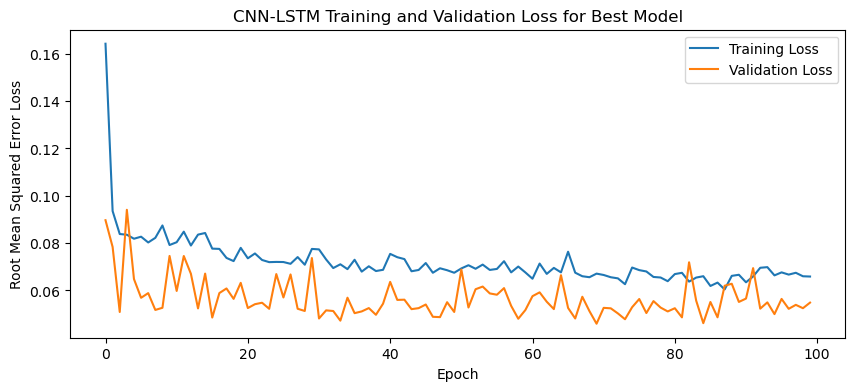

1/1 - 3s - loss: 0.0557 - 3s/epoch - 3s/step
Test Loss: 0.055738892406225204
Fold 2:
Epoch 1/100
19/19 [==============================] - 16s 269ms/step - loss: 0.1815 - val_loss: 0.1035
Epoch 2/100
19/19 [==============================] - 2s 108ms/step - loss: 0.0889 - val_loss: 0.0998
Epoch 3/100
19/19 [==============================] - 3s 166ms/step - loss: 0.0804 - val_loss: 0.0976
Epoch 4/100
19/19 [==============================] - 1s 62ms/step - loss: 0.0901 - val_loss: 0.0571
Epoch 5/100
19/19 [==============================] - 3s 177ms/step - loss: 0.0722 - val_loss: 0.0772
Epoch 6/100
19/19 [==============================] - 4s 205ms/step - loss: 0.0745 - val_loss: 0.0816
Epoch 7/100
19/19 [==============================] - 3s 170ms/step - loss: 0.0823 - val_loss: 0.0707
Epoch 8/100
19/19 [==============================] - 4s 183ms/step - loss: 0.0854 - val_loss: 0.0517
Epoch 9/100
19/19 [==============================] - 3s 152ms/step - loss: 0.0851 - val_loss: 0.0600
Epoch 

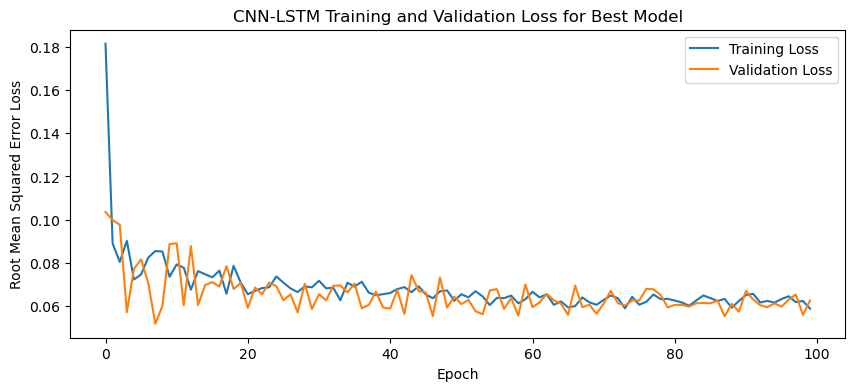

1/1 - 3s - loss: 0.0957 - 3s/epoch - 3s/step
Test Loss: 0.09574387967586517
Fold 3:
Epoch 1/100
19/19 [==============================] - 21s 376ms/step - loss: 0.1563 - val_loss: 0.0686
Epoch 2/100
19/19 [==============================] - 5s 265ms/step - loss: 0.0803 - val_loss: 0.0894
Epoch 3/100
19/19 [==============================] - 4s 211ms/step - loss: 0.0801 - val_loss: 0.0825
Epoch 4/100
19/19 [==============================] - 3s 164ms/step - loss: 0.0780 - val_loss: 0.0595
Epoch 5/100
19/19 [==============================] - 3s 183ms/step - loss: 0.0810 - val_loss: 0.0810
Epoch 6/100
19/19 [==============================] - 4s 208ms/step - loss: 0.0801 - val_loss: 0.0749
Epoch 7/100
19/19 [==============================] - 3s 148ms/step - loss: 0.0821 - val_loss: 0.0853
Epoch 8/100
19/19 [==============================] - 2s 99ms/step - loss: 0.0807 - val_loss: 0.0623
Epoch 9/100
19/19 [==============================] - 2s 116ms/step - loss: 0.0756 - val_loss: 0.0853
Epoch 1

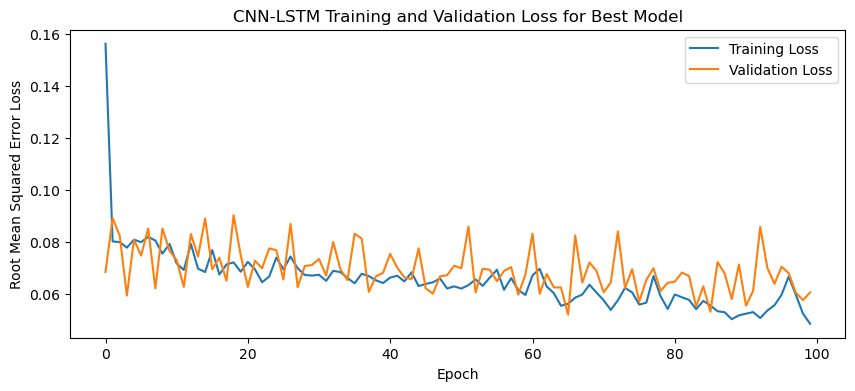

1/1 - 2s - loss: 0.0697 - 2s/epoch - 2s/step
Test Loss: 0.06965585052967072
Fold 4:
Epoch 1/100
20/20 [==============================] - 16s 295ms/step - loss: 0.2555 - val_loss: 0.2014
Epoch 2/100
20/20 [==============================] - 4s 187ms/step - loss: 0.1284 - val_loss: 0.1482
Epoch 3/100
20/20 [==============================] - 5s 239ms/step - loss: 0.1327 - val_loss: 0.1092
Epoch 4/100
20/20 [==============================] - 4s 227ms/step - loss: 0.1158 - val_loss: 0.0830
Epoch 5/100
20/20 [==============================] - 4s 198ms/step - loss: 0.1258 - val_loss: 0.1354
Epoch 6/100
20/20 [==============================] - 4s 218ms/step - loss: 0.1274 - val_loss: 0.0703
Epoch 7/100
20/20 [==============================] - 4s 187ms/step - loss: 0.1212 - val_loss: 0.0613
Epoch 8/100
20/20 [==============================] - 4s 228ms/step - loss: 0.1040 - val_loss: 0.1084
Epoch 9/100
20/20 [==============================] - 4s 185ms/step - loss: 0.1110 - val_loss: 0.0991
Epoch 

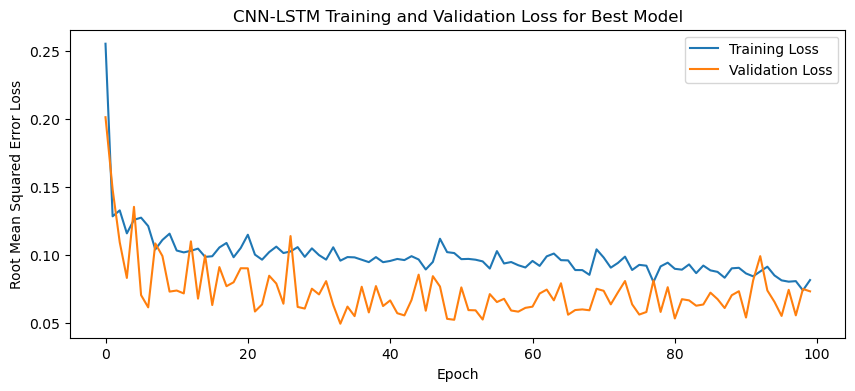

1/1 - 4s - loss: 0.0736 - 4s/epoch - 4s/step
Test Loss: 0.0735553726553917
Fold 5:
Epoch 1/100
19/19 [==============================] - 24s 450ms/step - loss: 0.1771 - val_loss: 0.0889
Epoch 2/100
19/19 [==============================] - 3s 150ms/step - loss: 0.0866 - val_loss: 0.0965
Epoch 3/100
19/19 [==============================] - 3s 144ms/step - loss: 0.0929 - val_loss: 0.0875
Epoch 4/100
19/19 [==============================] - 3s 161ms/step - loss: 0.0846 - val_loss: 0.0895
Epoch 5/100
19/19 [==============================] - 3s 181ms/step - loss: 0.0845 - val_loss: 0.0918
Epoch 6/100
19/19 [==============================] - 4s 210ms/step - loss: 0.0742 - val_loss: 0.0949
Epoch 7/100
19/19 [==============================] - 2s 133ms/step - loss: 0.0744 - val_loss: 0.0806
Epoch 8/100
19/19 [==============================] - 3s 159ms/step - loss: 0.0805 - val_loss: 0.0823
Epoch 9/100
19/19 [==============================] - 2s 120ms/step - loss: 0.0684 - val_loss: 0.0601
Epoch 1

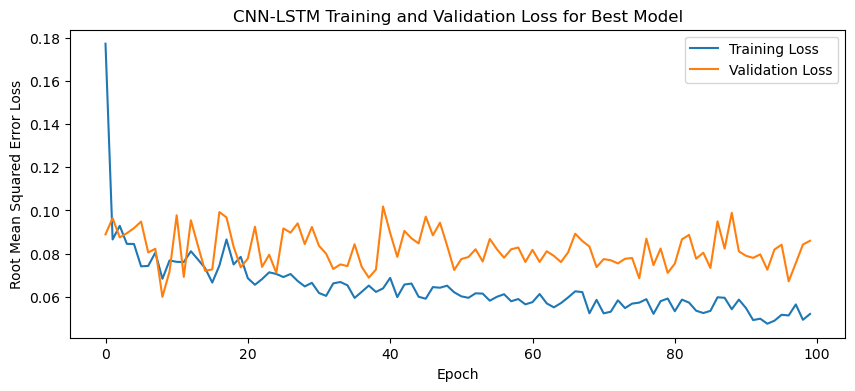

1/1 - 3s - loss: 0.0506 - 3s/epoch - 3s/step
Test Loss: 0.050620753318071365


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

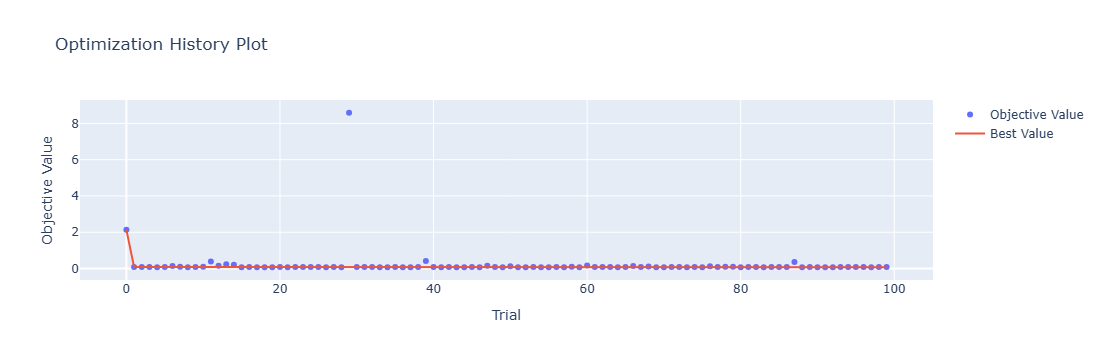

In [4]:
optuna.visualization.plot_optimization_history(study)

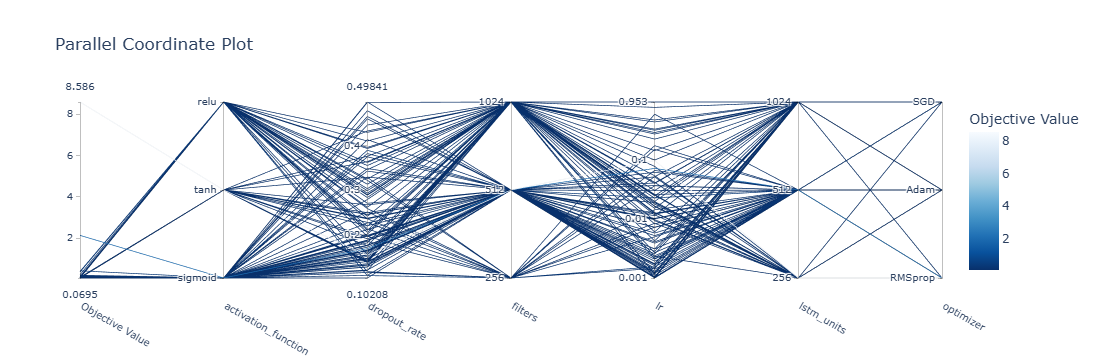

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

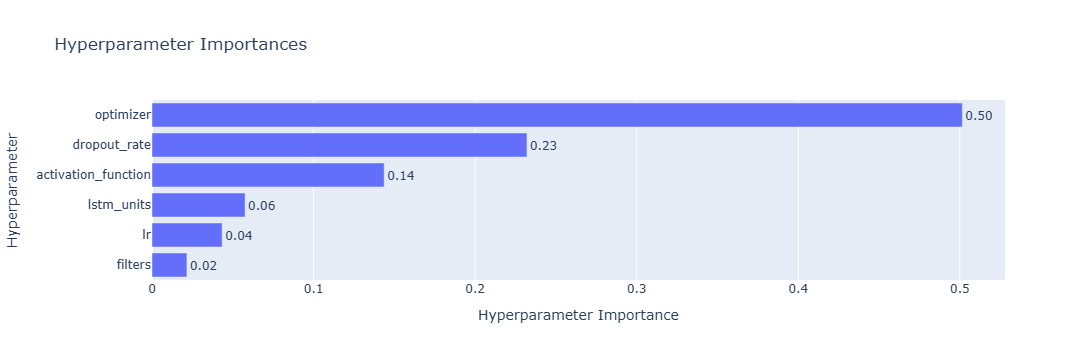

In [6]:
optuna.visualization.plot_param_importances(study)

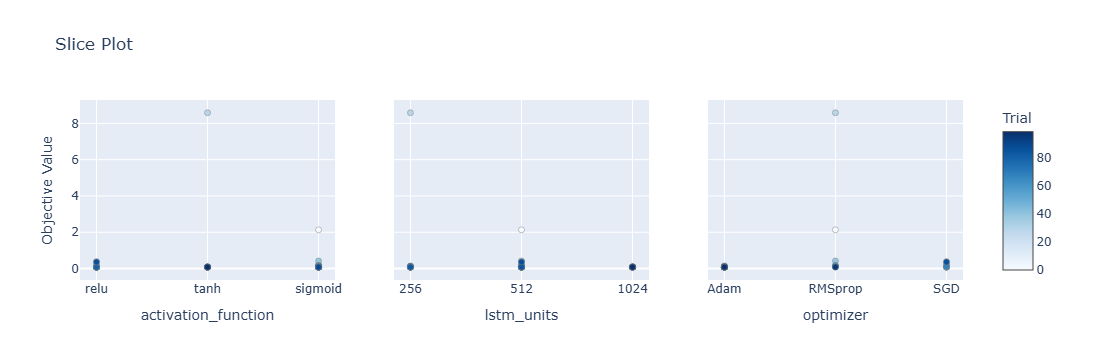

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

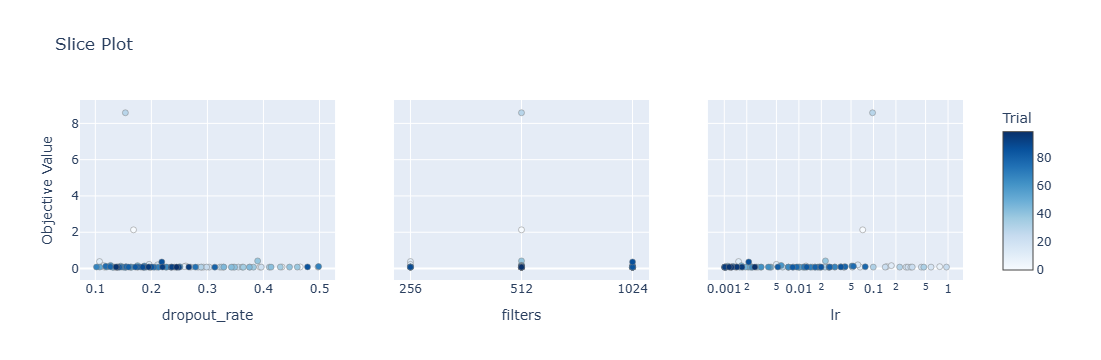

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 19s 369ms/step - loss: 0.1912 - accuracy: 0.2632 - mae: 0.1711 - rmse: 0.1912 - mape: 42.9782 - pearson: 0.2099 - val_loss: 0.0925 - val_accuracy: 0.0000e+00 - val_mae: 0.0700 - val_rmse: 0.0925 - val_mape: 15.8315 - val_pearson: 0.5182
Epoch 2/100
19/19 [==============================] - 3s 140ms/step - loss: 0.1214 - accuracy: 0.2632 - mae: 0.0977 - rmse: 0.1214 - mape: 24.6578 - pearson: 0.1574 - val_loss: 0.0785 - val_accuracy: 0.6667 - val_mae: 0.0673 - val_rmse: 0.0785 - val_mape: 16.4935 - val_pearson: 0.5935
Epoch 3/100
19/19 [==============================] - 2s 128ms/step - loss: 0.1121 - ac

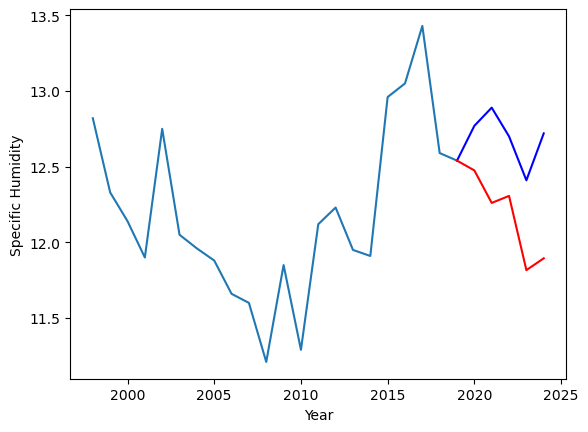

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.73		-0.15
10.09		9.51		-0.58
9.65		9.55		-0.10
9.13		9.06		-0.07
9.32		9.14		-0.18


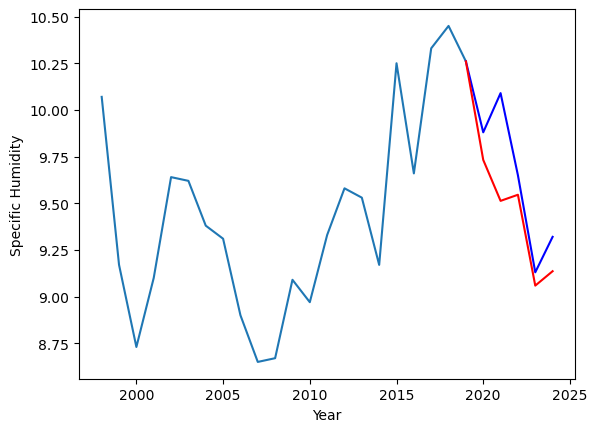

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.475348
1                1    9.88   9.732244


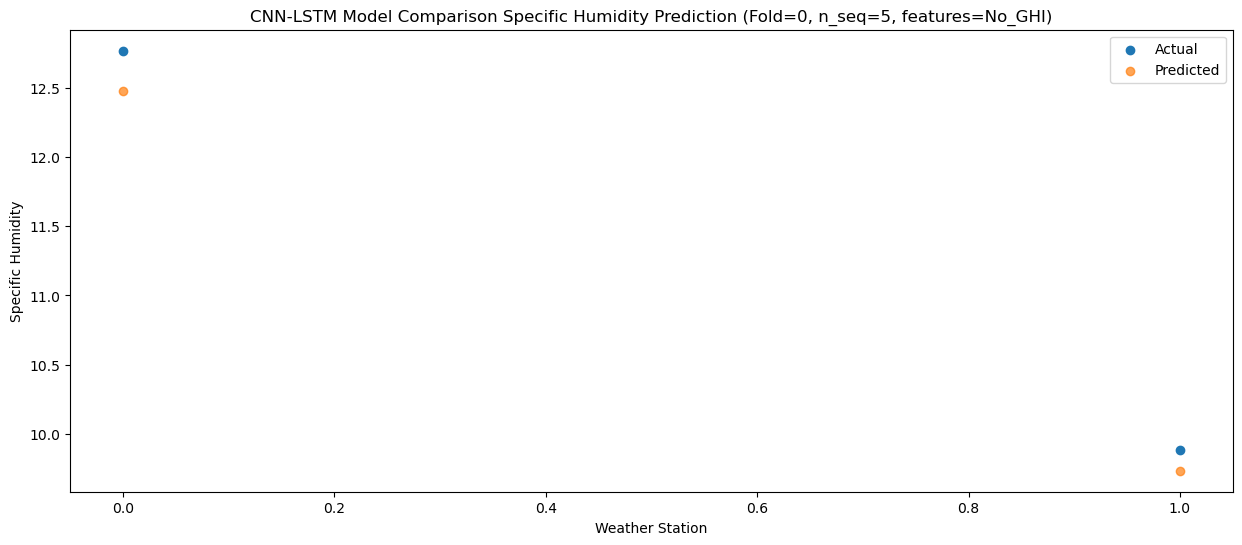

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.260589
1                1   10.09   9.512821


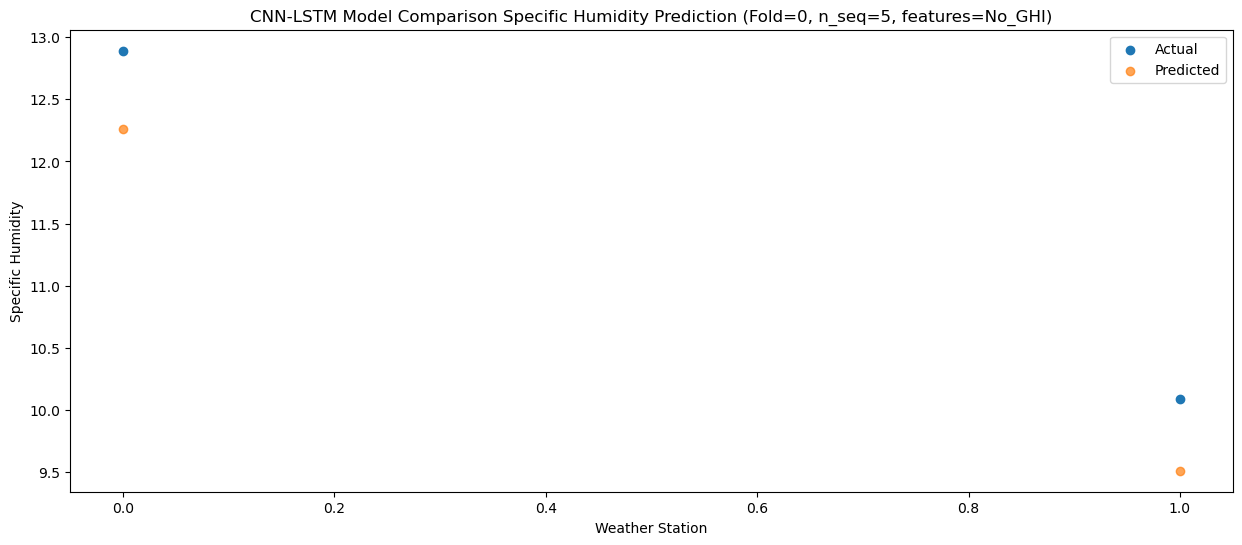

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.306847
1                1    9.65   9.545529


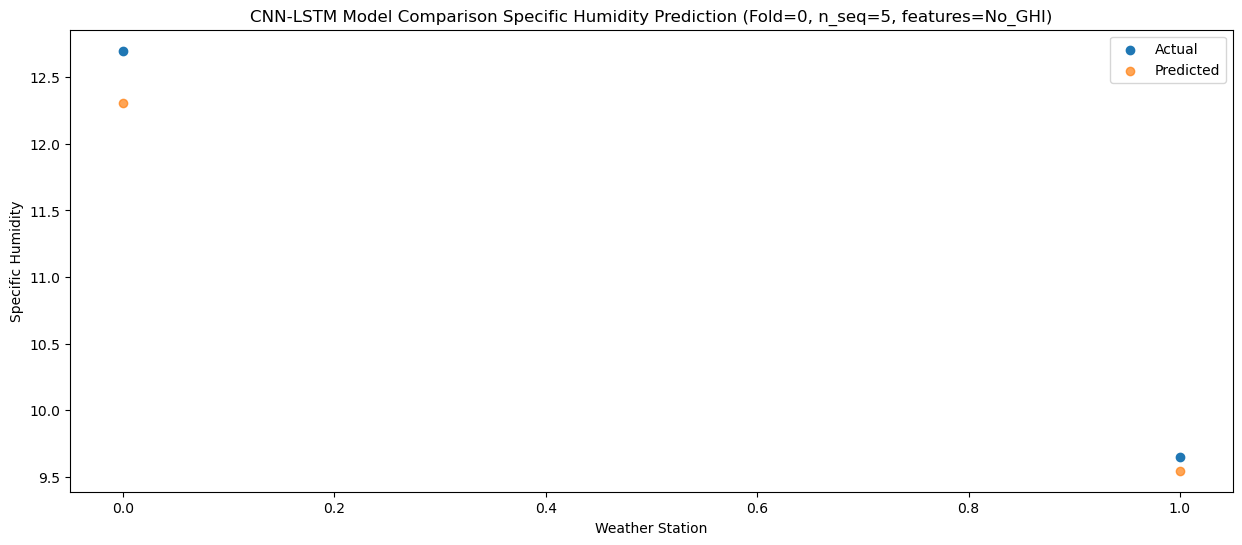

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  11.816520
1                1    9.13   9.058818


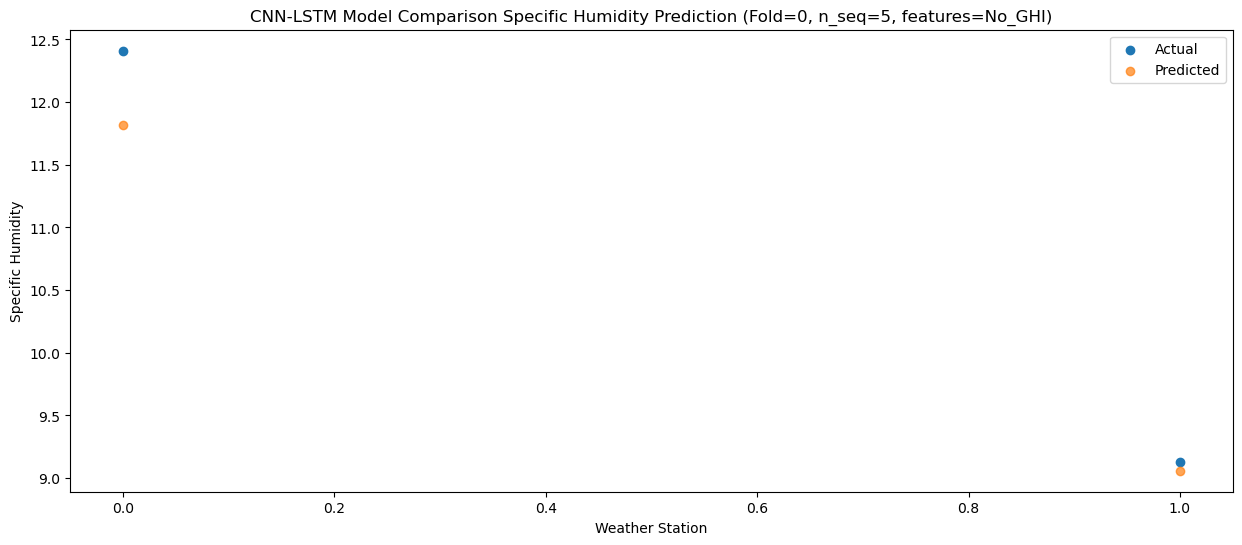

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  11.894668
1                1    9.32   9.135989


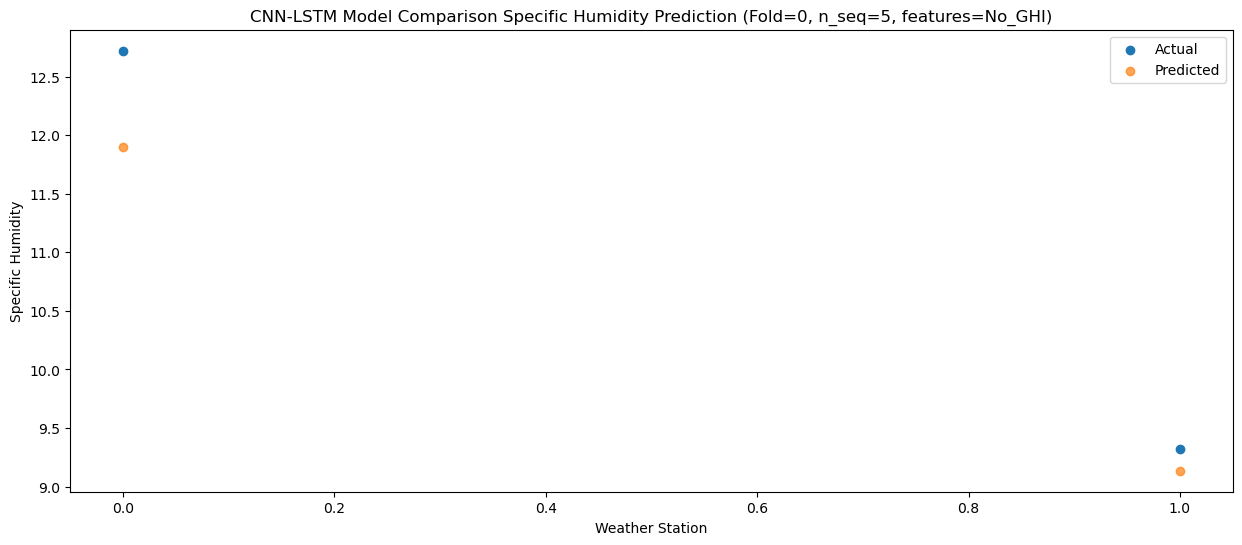

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.4753477   9.73224357]
 [12.26058938  9.51282149]
 [12.30684666  9.54552904]
 [11.81652013  9.05881838]
 [11.89466757  9.13598939]]
Year at t+1:
t+1 SKRMSE: 0.233079
t+1 KRMSE: 0.233079
t+1 MAE: 0.221204
t+1 SKMAPE: 0.019014
t+1 R2_SCORE: 0.973982
t+1 KMAPE: 0.019014
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.603860
t+2 KRMSE: 0.603860
t+2 MAE: 0.603295
t+2 SKMAPE: 0.053016
t+2 R2_SCORE: 0.813956
t+2 KMAPE: 0.053016
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.287649
t+3 KRMSE: 0.287649
t+3 MAE: 0.248812
t+3 SKMAPE: 0.020891
t+3 R2_SCORE: 0.964422
t+3 KMAPE: 0.020891
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.422661
t+4 KRMSE: 0.422661
t+4 MAE: 0.332331
t+4 SKMAPE: 0.027810
t+4 R2_SCORE: 0.933580
t+4 KMAPE: 0.027810
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.597

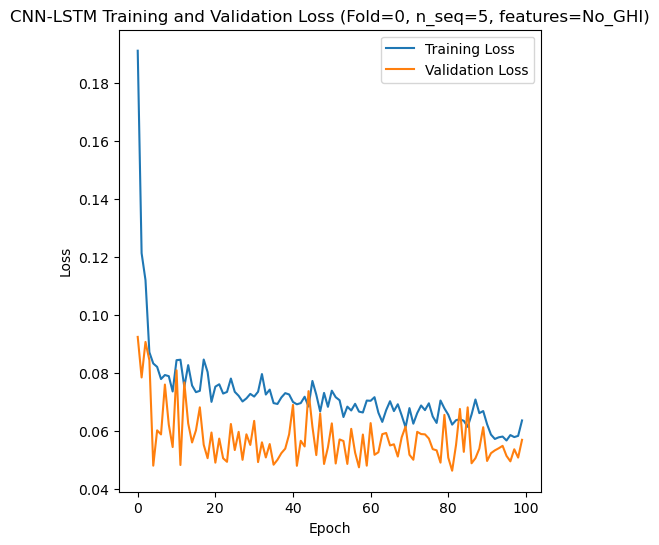

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 24s 464ms/step - loss: 0.1678 - accuracy: 0.2632 - mae: 0.1506 - rmse: 0.1678 - mape: 35.8774 - pearson: 0.2587 - val_loss: 0.0766 - val_accuracy: 0.3333 - val_mae: 0.0700 - val_rmse: 0.0766 - val_mape: 17.7081 - val_pearson: 0.3723
Epoch 2/100
19/19 [==============================] - 4s 191ms/step - loss: 0.0918 - accuracy: 0.4211 - mae: 0.0769 - rmse: 0.0918 - mape: 19.2661 - pearson: 0.2796 - val_loss: 0.0741 - val_accuracy: 0.3333 - val_mae: 0.0631 - val_rmse: 0.0741 - val_mape: 15.2662 - val_pearson: 0.4159
Epoch 3/100
19/19 [==============================] - 3s 157ms/step - loss: 0.0799 - accura

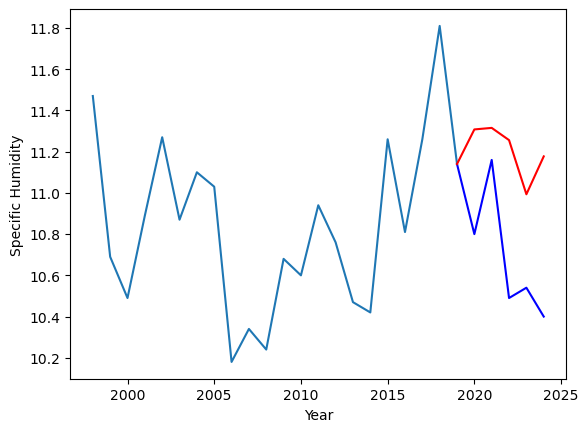

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		7.51		-0.15
6.92		7.60		0.68
7.36		7.65		0.29
6.79		7.43		0.64
6.94		7.67		0.73


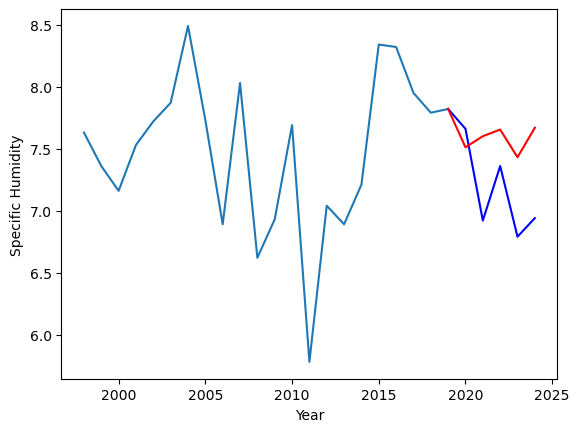

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  11.307860
1                1    7.66   7.510872


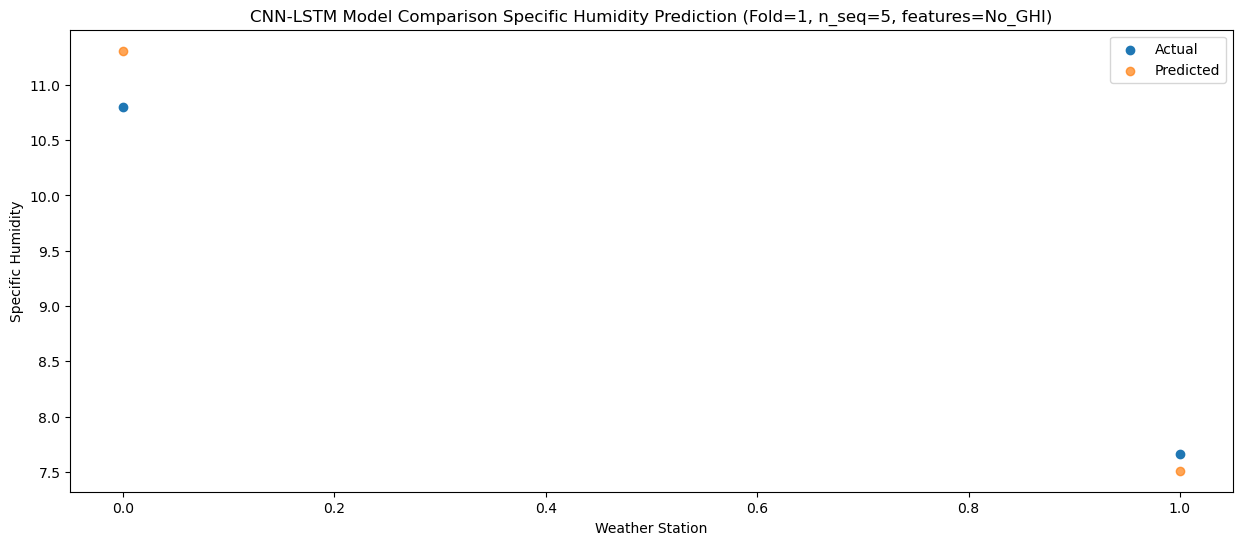

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  11.315373
1                1    6.92   7.600592


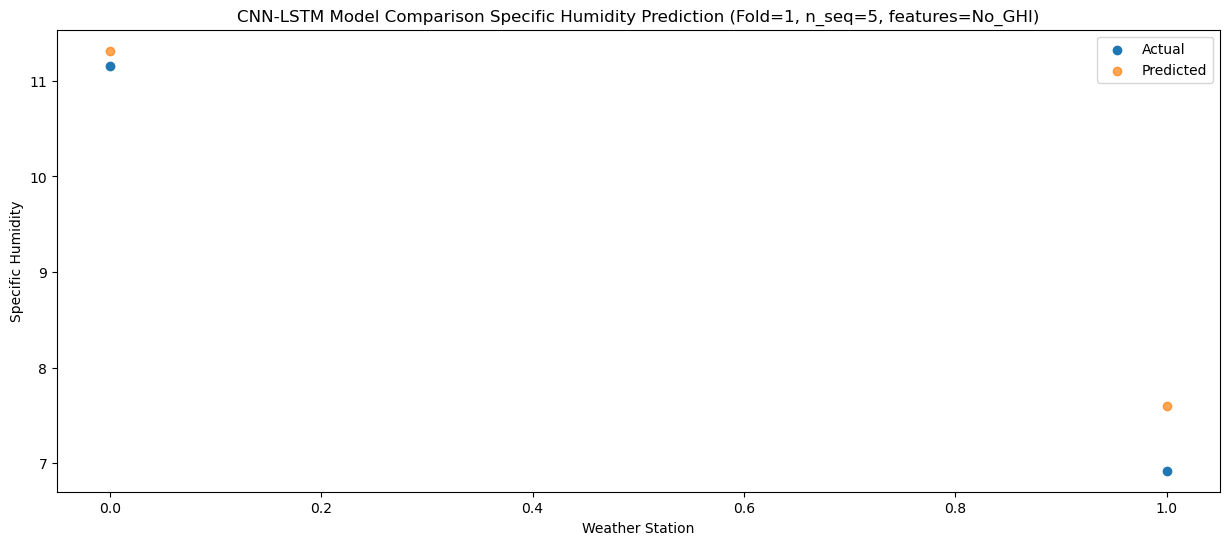

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.256006
1                1    7.36   7.654112


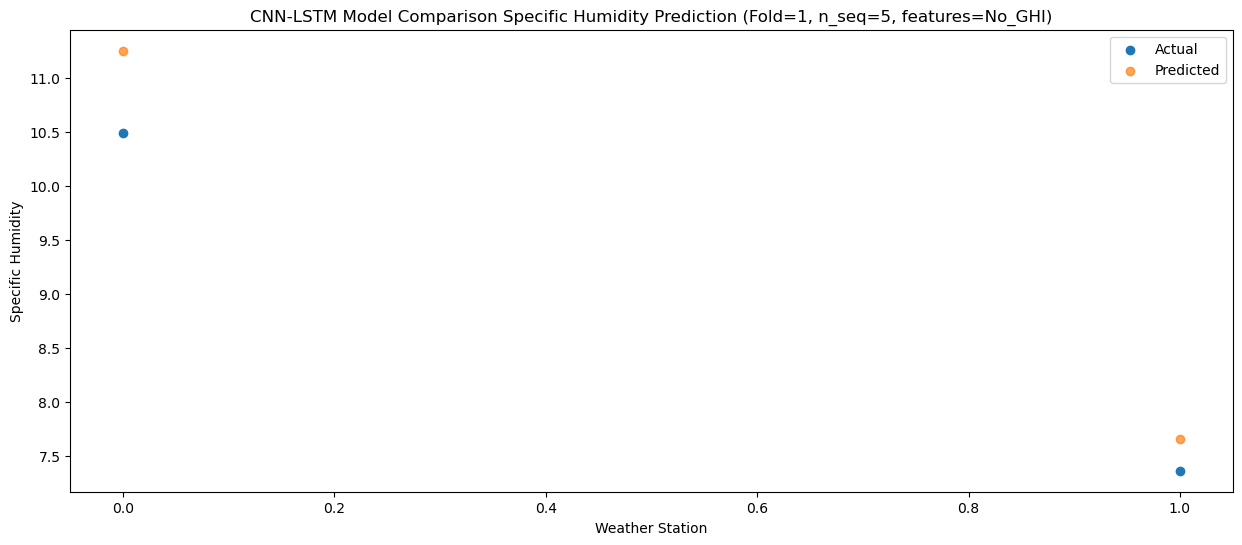

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.993257
1                1    6.79   7.430965


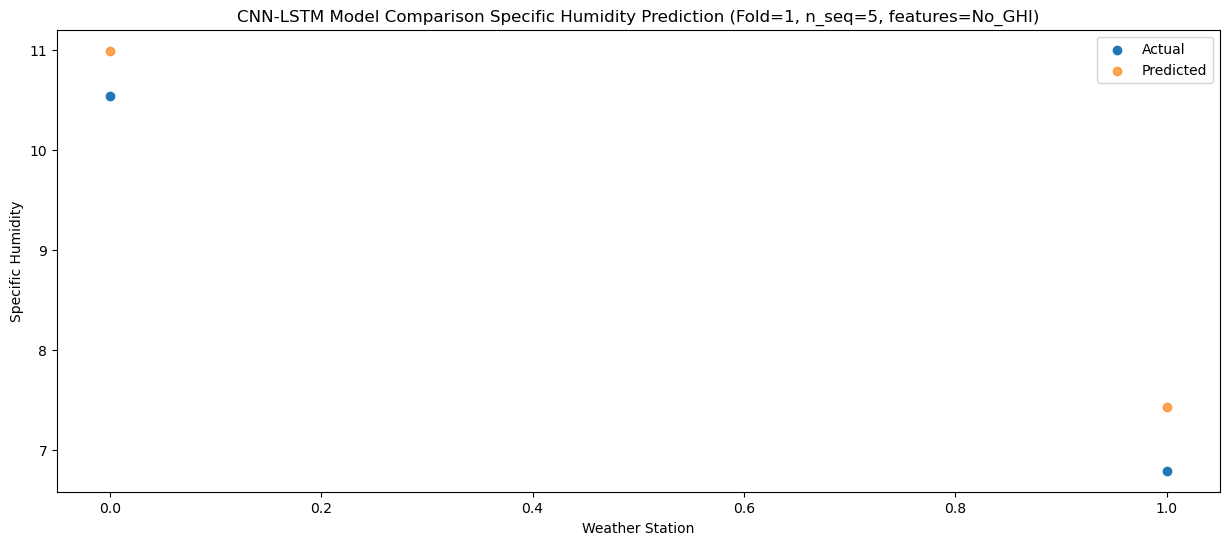

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  11.177063
1                1    6.94   7.668987


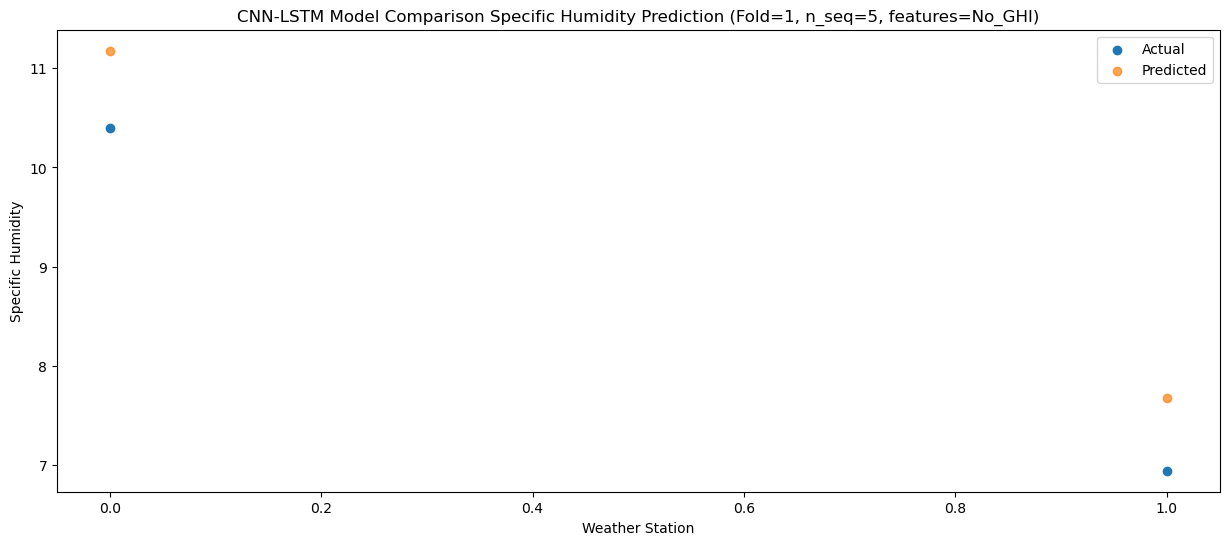

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[11.30786009  7.51087153]
 [11.31537263  7.60059152]
 [11.25600613  7.65411153]
 [10.99325685  7.43096482]
 [11.17706257  7.66898721]]
Year at t+1:
t+1 SKRMSE: 0.374273
t+1 KRMSE: 0.374273
t+1 MAE: 0.328494
t+1 SKMAPE: 0.033246
t+1 R2_SCORE: 0.943170
t+1 KMAPE: 0.033246
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.493632
t+2 KRMSE: 0.493632
t+2 MAE: 0.417982
t+2 SKMAPE: 0.056137
t+2 R2_SCORE: 0.945783
t+2 KMAPE: 0.056137
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.580201
t+3 KRMSE: 0.580201
t+3 MAE: 0.530059
t+3 SKMAPE: 0.056492
t+3 R2_SCORE: 0.862555
t+3 KMAPE: 0.056492
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.555103
t+4 KRMSE: 0.555103
t+4 MAE: 0.547111
t+4 SKMAPE: 0.068701
t+4 R2_SCORE: 0.912352
t+4 KMAPE: 0.068701
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.753408


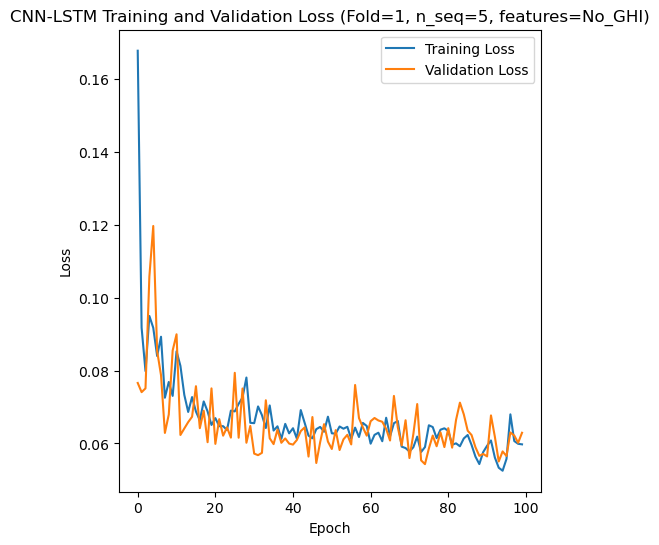

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 26s 475ms/step - loss: 0.1786 - accuracy: 0.3158 - mae: 0.1576 - rmse: 0.1786 - mape: 37.1948 - pearson: 0.3436 - val_loss: 0.1386 - val_accuracy: 0.3333 - val_mae: 0.1169 - val_rmse: 0.1386 - val_mape: 26.5852 - val_pearson: 0.3442
Epoch 2/100
19/19 [==============================] - 2s 111ms/step - loss: 0.0985 - accuracy: 0.4211 - mae: 0.0831 - rmse: 0.0985 - mape: 19.9700 - pearson: 0.3717 - val_loss: 0.0784 - val_accuracy: 0.6667 - val_mae: 0.0606 - val_rmse: 0.0784 - val_mape: 14.7684 - val_pearson: 0.5142
Epoch 3/100
19/19 [==============================] - 2s 113ms/step - loss: 0.0849 - accura

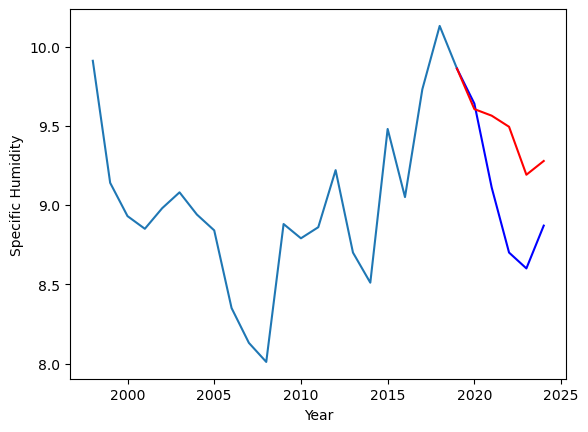

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		8.07		0.23
7.66		7.89		0.23
7.73		8.11		0.38
8.00		7.69		-0.31
8.01		7.81		-0.20


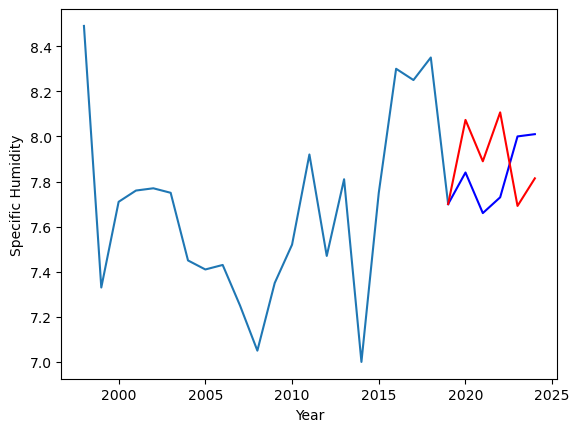

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.605148
1                1    7.84   8.073215


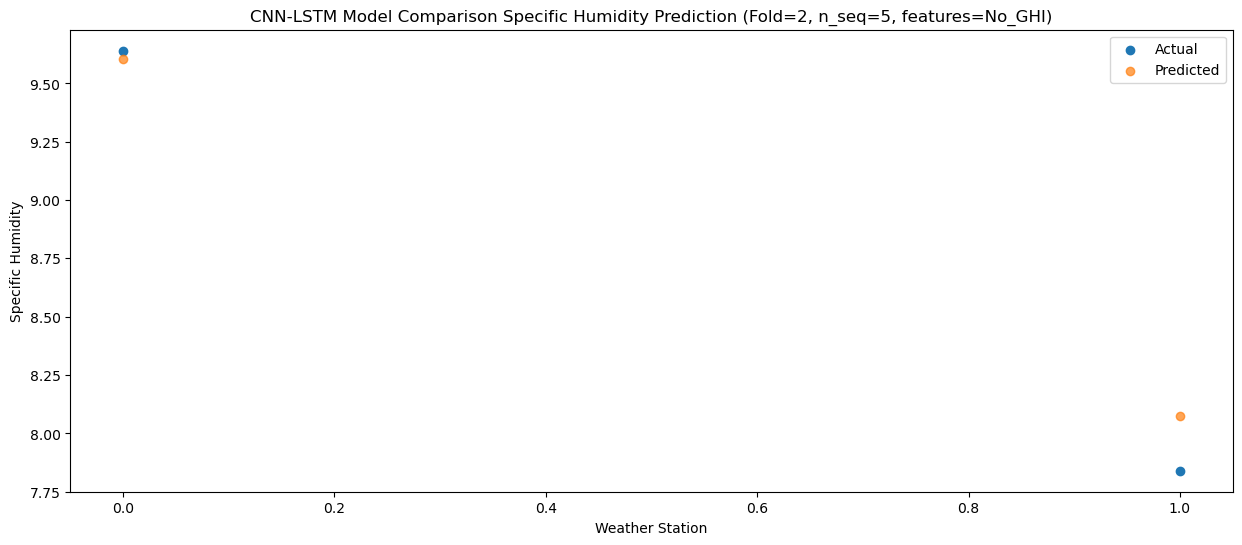

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.563677
1                1    7.66   7.889711


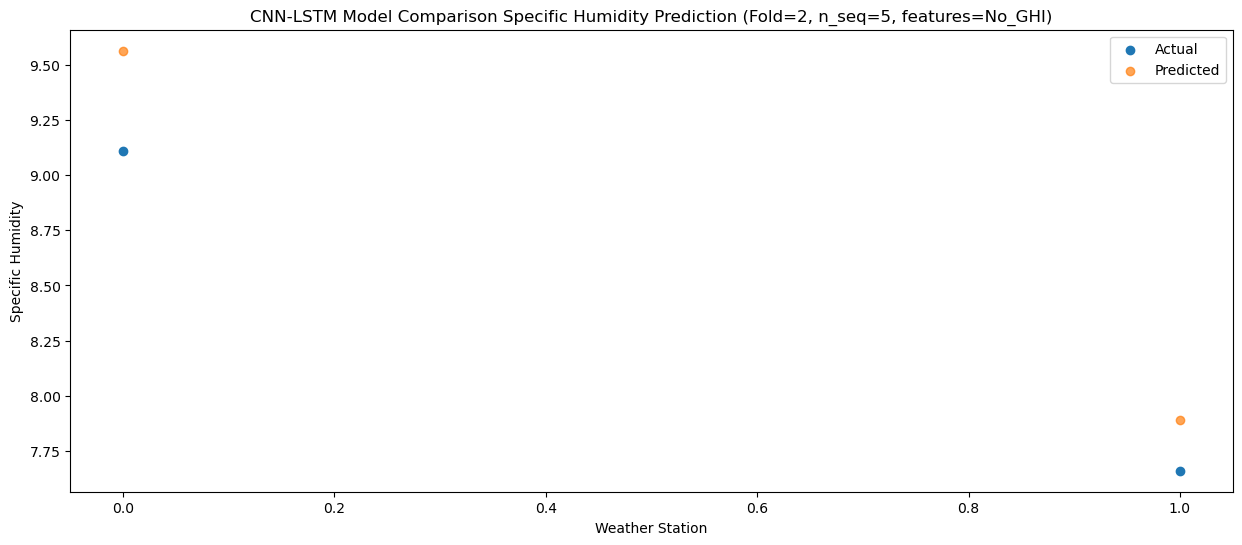

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.493711
1                1    7.73   8.106651


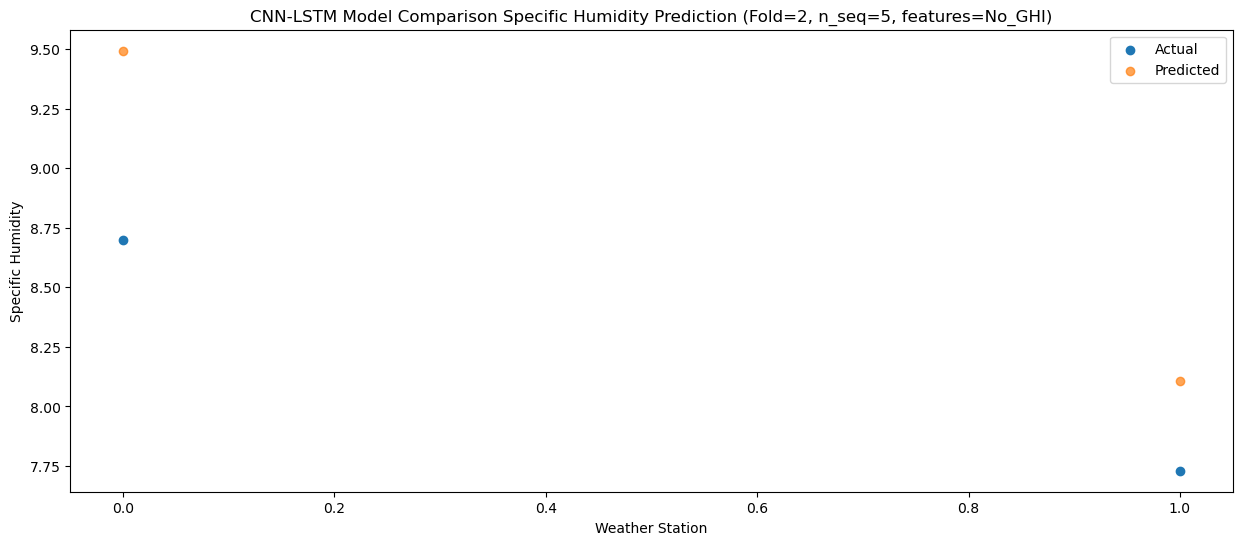

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.191054
1                1     8.0   7.691724


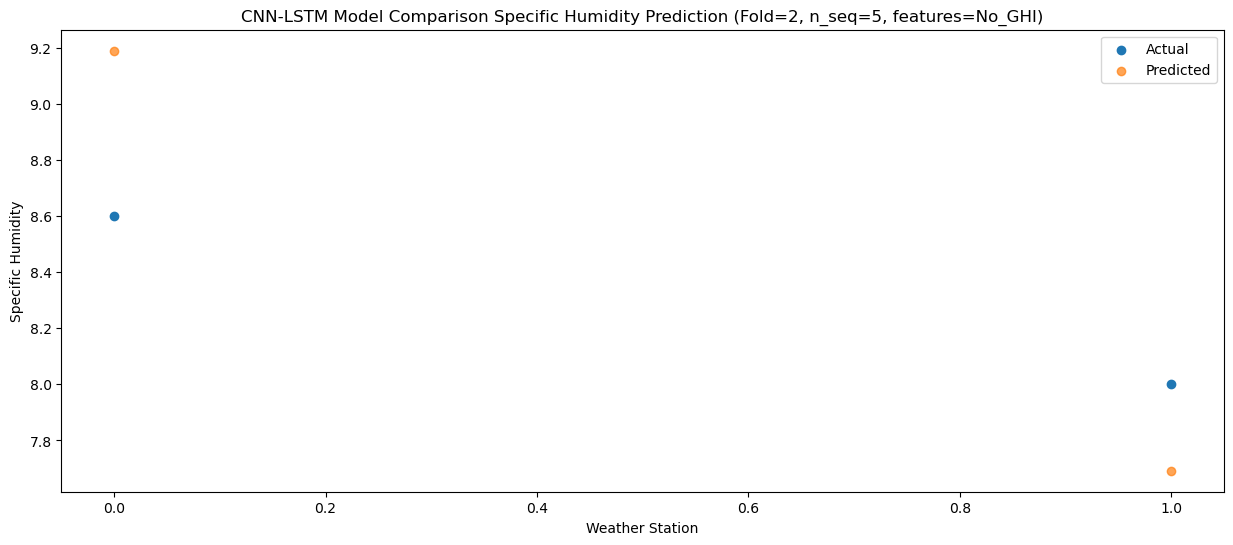

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87    9.27789
1                1    8.01    7.81408


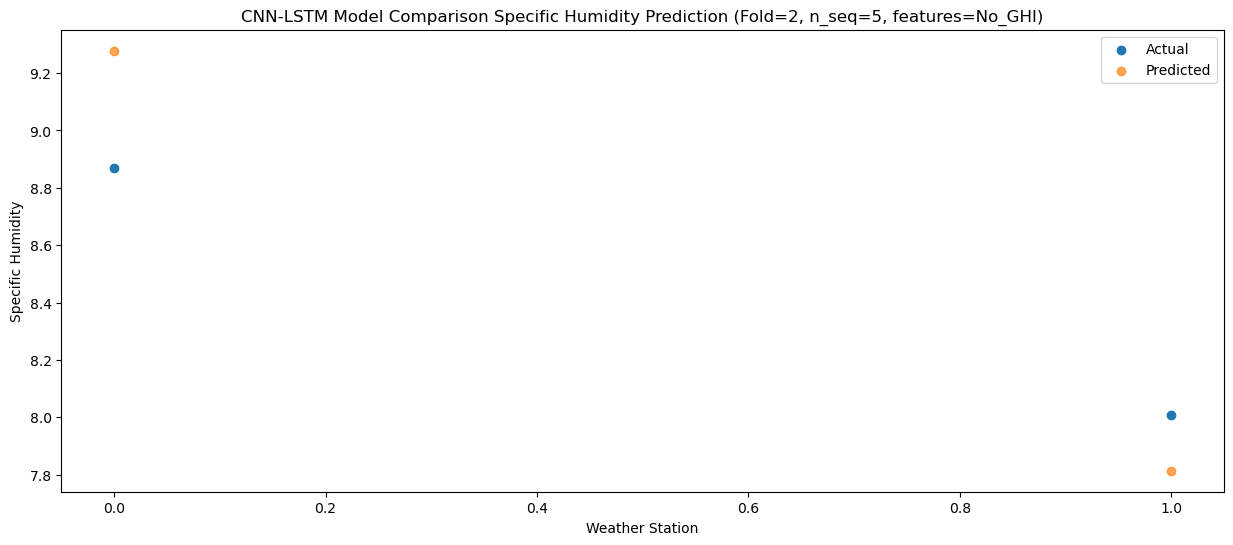

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.60514757 8.07321494]
 [9.56367712 7.88971074]
 [9.49371111 8.10665066]
 [9.19105449 7.69172445]
 [9.27789035 7.8140799 ]]
Year at t+1:
t+1 SKRMSE: 0.166739
t+1 KRMSE: 0.166739
t+1 MAE: 0.134034
t+1 SKMAPE: 0.016681
t+1 R2_SCORE: 0.965677
t+1 KMAPE: 0.016681
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.359576
t+2 KRMSE: 0.359576
t+2 MAE: 0.341694
t+2 SKMAPE: 0.039894
t+2 R2_SCORE: 0.754017
t+2 KMAPE: 0.039894
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 0.621226
t+3 KRMSE: 0.621226
t+3 MAE: 0.585181
t+3 SKMAPE: 0.069978
t+3 R2_SCORE: -0.640648
t+3 KMAPE: 0.069978
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.471370
t+4 KRMSE: 0.471370
t+4 MAE: 0.449665
t+4 SKMAPE: 0.053631
t+4 R2_SCORE: -1.468773
t+4 KMAPE: 0.053631
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.319968
t+5 KRMSE: 0.31996

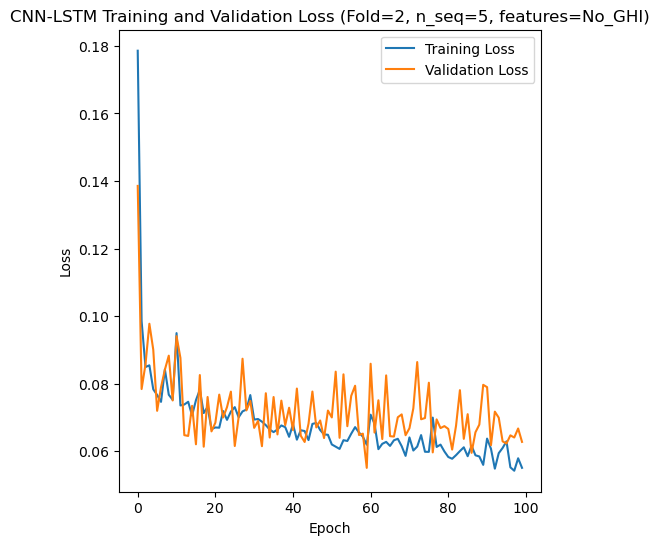

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 22s 337ms/step - loss: 0.2367 - accuracy: 0.2000 - mae: 0.2106 - rmse: 0.2367 - mape: 37.1558 - pearson: 0.4194 - val_loss: 0.0597 - val_accuracy: 0.0000e+00 - val_mae: 0.0462 - val_rmse: 0.0597 - val_mape: 8.3899 - val_pearson: 0.7564
Epoch 2/100
20/20 [==============================] - 1s 70ms/step - loss: 0.1356 - accuracy: 0.2000 - mae: 0.1112 - rmse: 0.1356 - mape: 19.5956 - pearson: 0.2595 - val_loss: 0.0906 - val_accuracy: 0.0000e+00 - val_mae: 0.0785 - val_rmse: 0.0906 - val_mape: 12.4542 - val_pearson: 0.8447
Epoch 3/100
20/20 [==============================] - 1s 70ms/step - loss: 0.1198 - accuracy: 0.3000 - mae: 0.1010 - rmse: 0.1198 - mape: 18.08

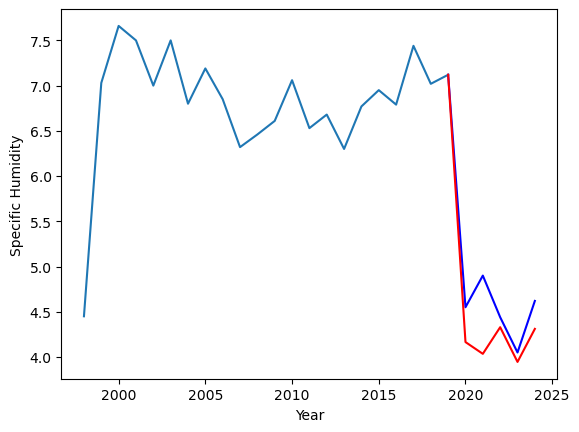

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		8.07		-0.14
8.12		7.88		-0.24
8.09		8.21		0.12
7.62		7.76		0.14
7.64		8.15		0.51


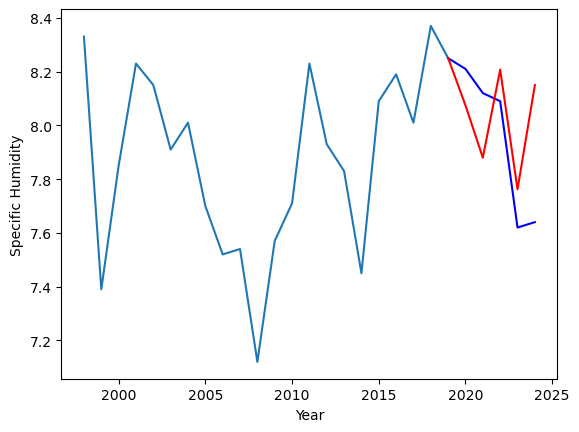

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.165065
1                1    8.21   8.074270


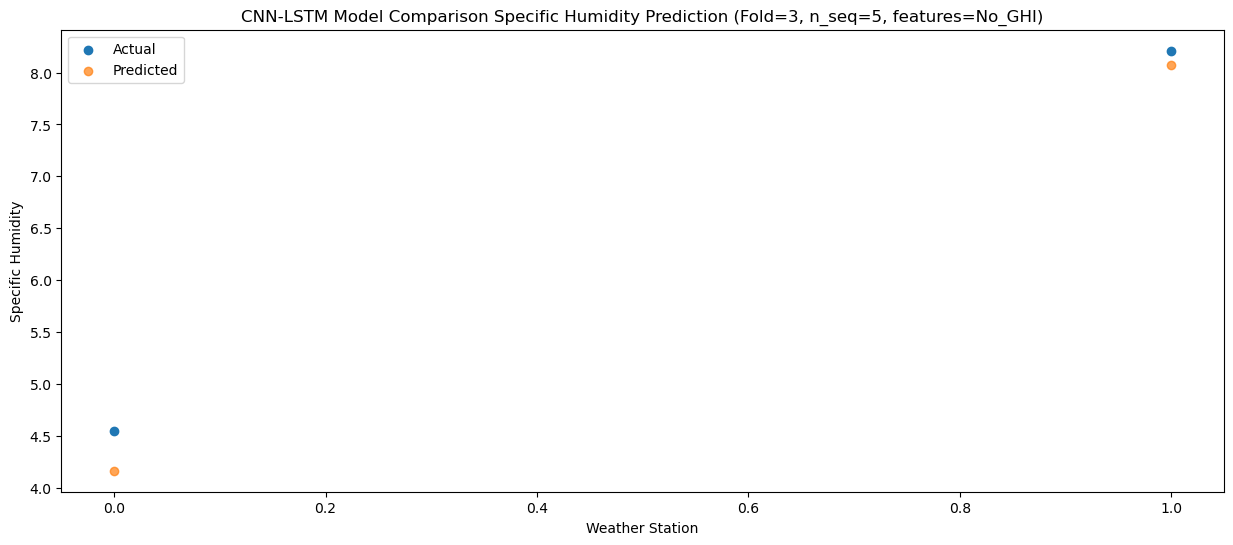

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   4.034969
1                1    8.12   7.879733


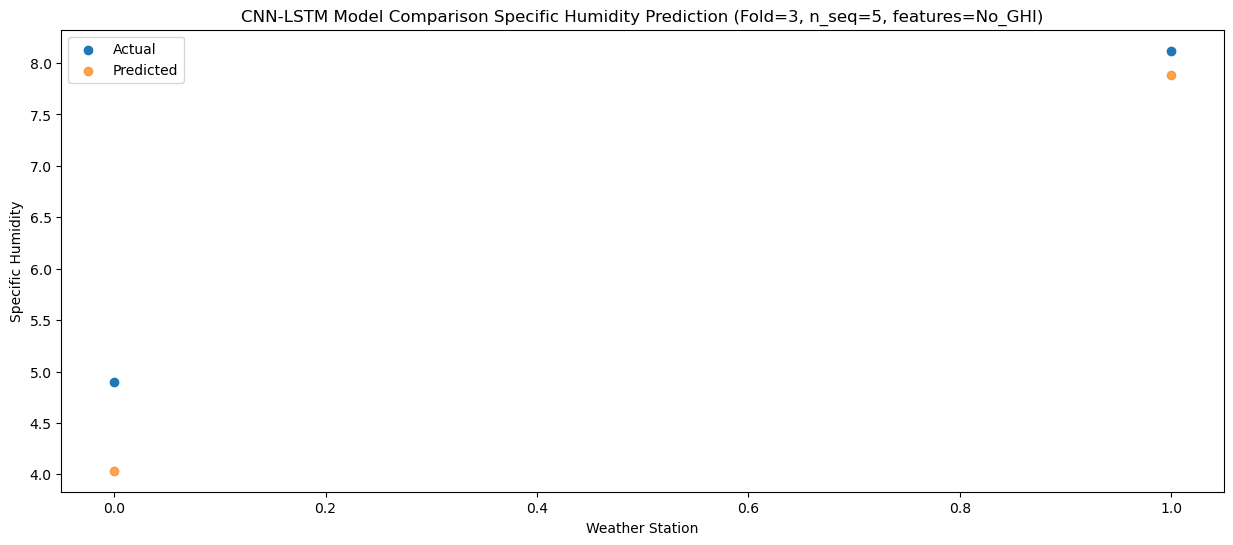

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.329453
1                1    8.09   8.207587


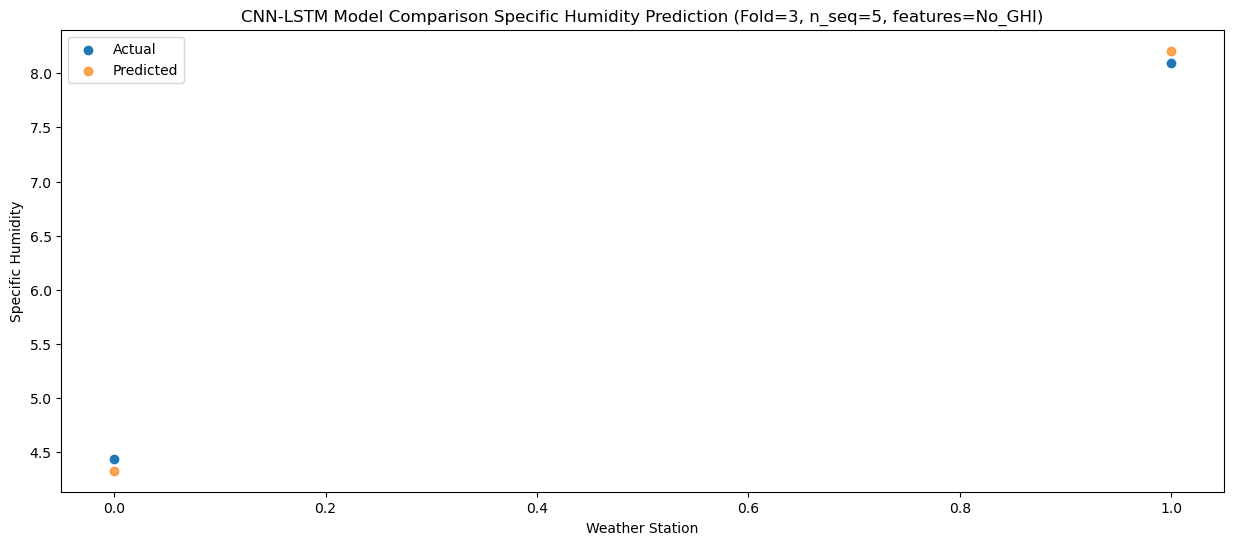

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.945592
1                1    7.62   7.762007


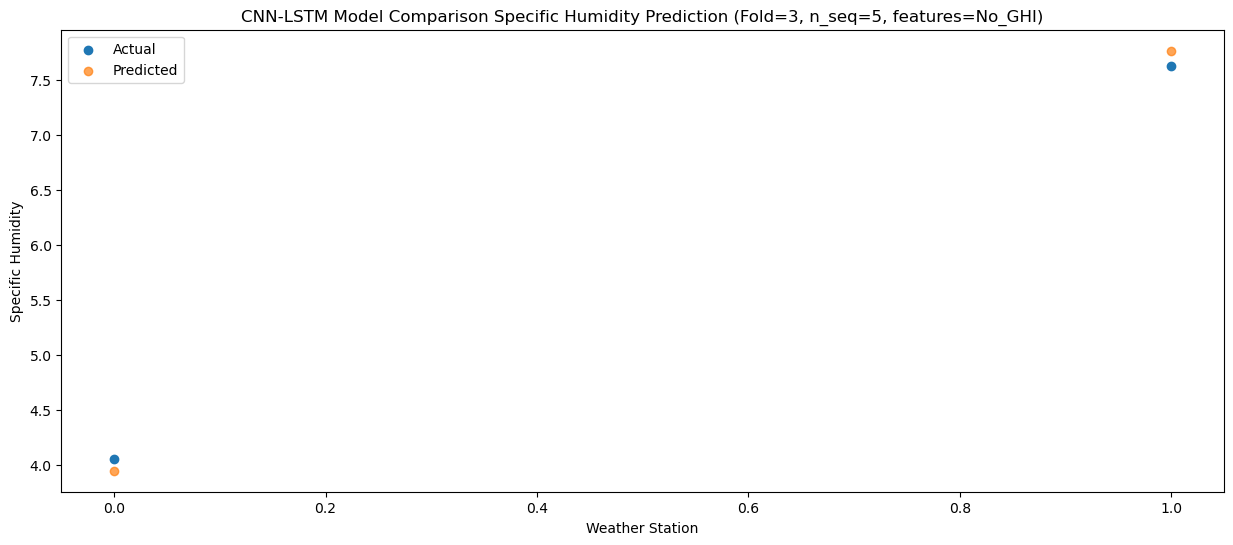

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   4.310866
1                1    7.64   8.149803


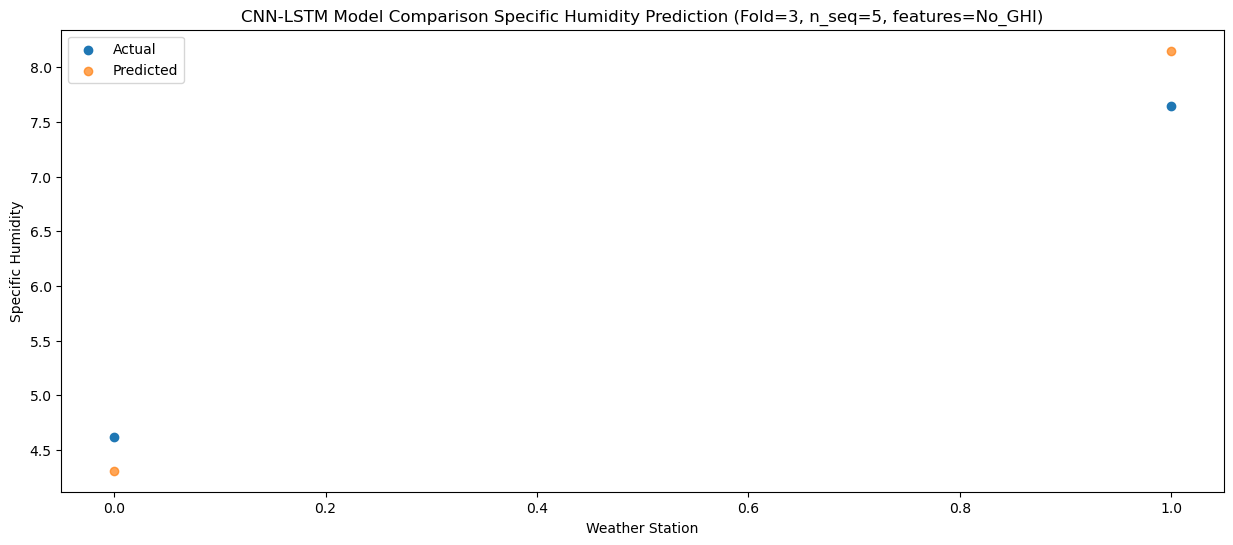

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.16506539 8.07426982]
 [4.03496878 7.87973334]
 [4.32945348 8.20758681]
 [3.94559167 7.76200678]
 [4.31086586 8.14980312]]
Year at t+1:
t+1 SKRMSE: 0.288615
t+1 KRMSE: 0.288615
t+1 MAE: 0.260332
t+1 SKMAPE: 0.050567
t+1 R2_SCORE: 0.975127
t+1 KMAPE: 0.050567
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.634826
t+2 KRMSE: 0.634826
t+2 MAE: 0.552649
t+2 SKMAPE: 0.103063
t+2 R2_SCORE: 0.844526
t+2 KMAPE: 0.103063
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.114121
t+3 KRMSE: 0.114121
t+3 MAE: 0.114067
t+3 SKMAPE: 0.019716
t+3 R2_SCORE: 0.996090
t+3 KMAPE: 0.019716
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.124634
t+4 KRMSE: 0.124634
t+4 MAE: 0.123208
t+4 SKMAPE: 0.022208
t+4 R2_SCORE: 0.995125
t+4 KMAPE: 0.022208
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.421582
t+5 KRMSE: 0.421582


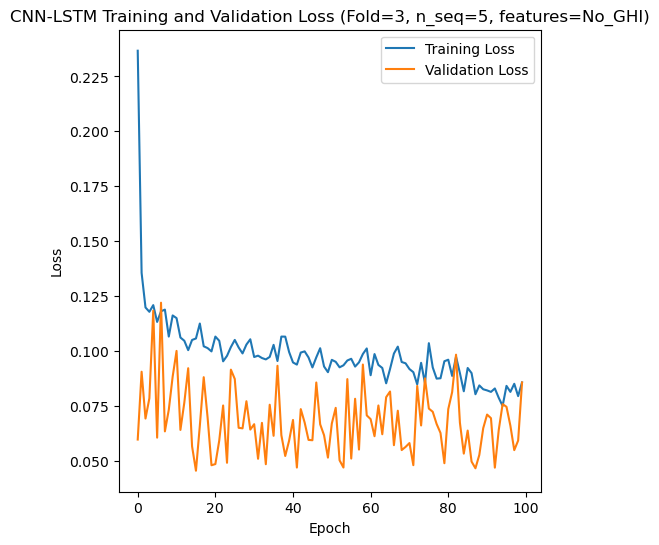

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 20s 343ms/step - loss: 0.1652 - accuracy: 0.2105 - mae: 0.1446 - rmse: 0.1652 - mape: 34.2844 - pearson: 0.2999 - val_loss: 0.1097 - val_accuracy: 0.0000e+00 - val_mae: 0.0885 - val_rmse: 0.1097 - val_mape: 22.3470 - val_pearson: 0.0870
Epoch 2/100
19/19 [==============================] - 2s 90ms/step - loss: 0.1067 - accuracy: 0.2632 - mae: 0.0901 - rmse: 0.1067 - mape: 21.4980 - pearson: 0.3149 - val_loss: 0.1189 - val_accuracy: 0.0000e+00 - val_mae: 0.0997 - val_rmse: 0.1189 - val_mape: 23.0954 - val_pearson: 0.3342
Epoch 3/100
19/19 [==============================] - 2s 93ms/step - loss: 0.0853 - a

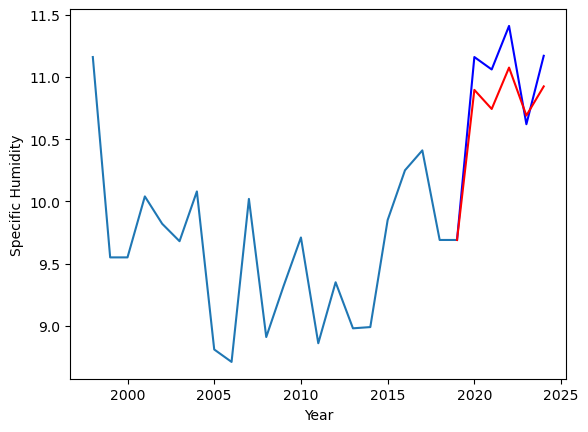

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		8.06		0.27
7.52		7.99		0.47
7.85		8.21		0.36
7.25		7.88		0.63
7.48		8.08		0.60


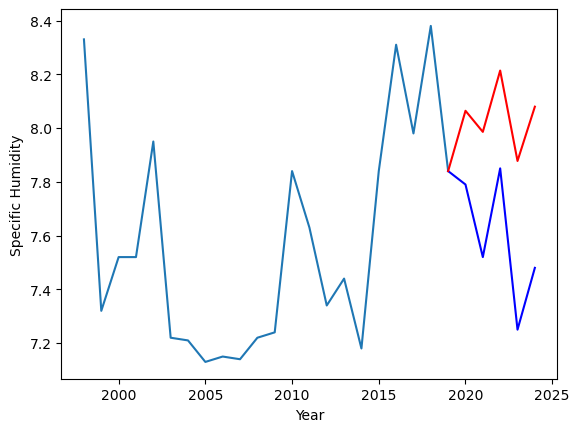

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.895919
1                1    7.79   8.064294


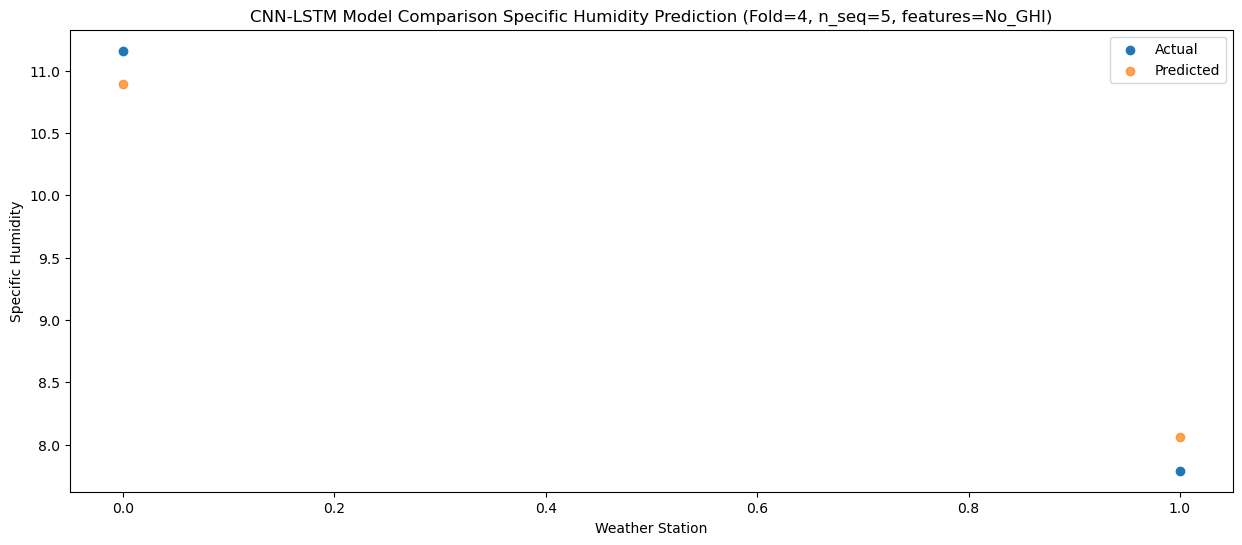

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.742727
1                1    7.52   7.985850


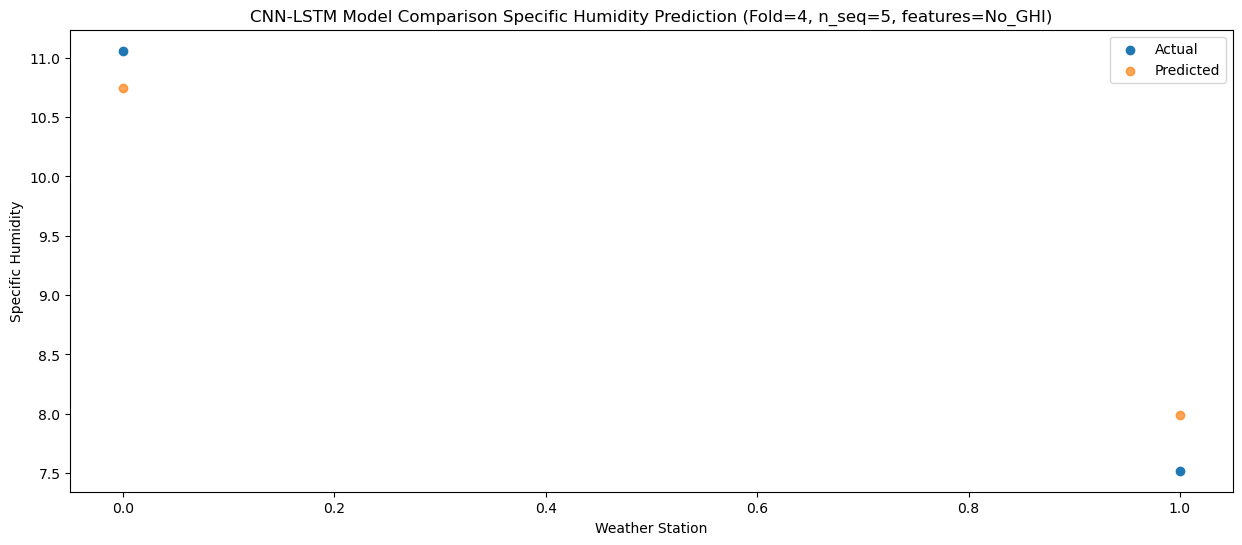

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  11.075191
1                1    7.85   8.213949


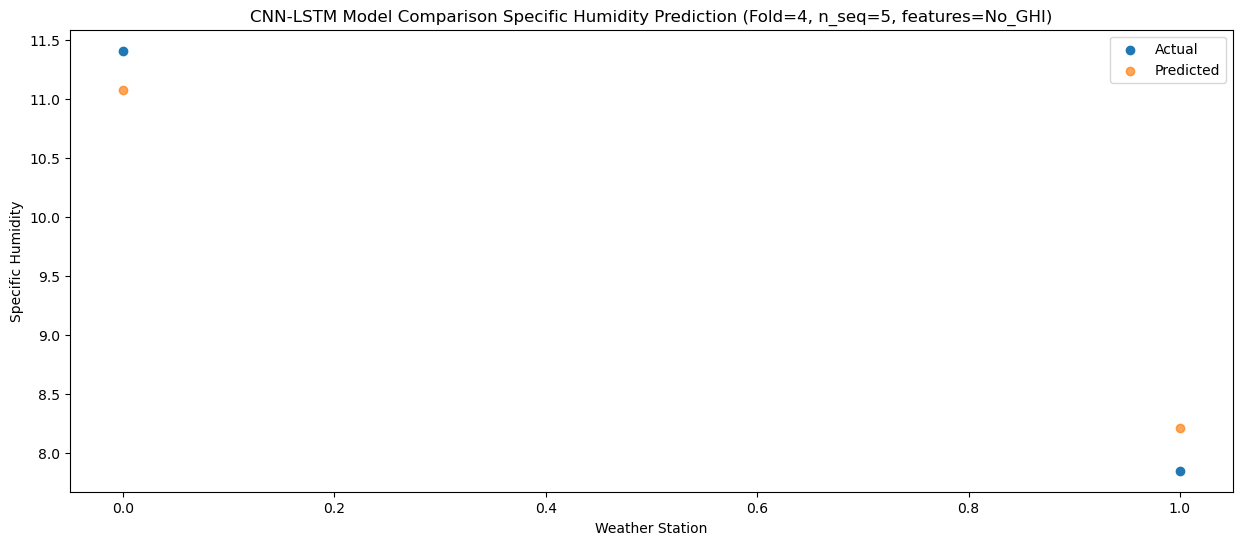

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.689822
1                1    7.25   7.877610


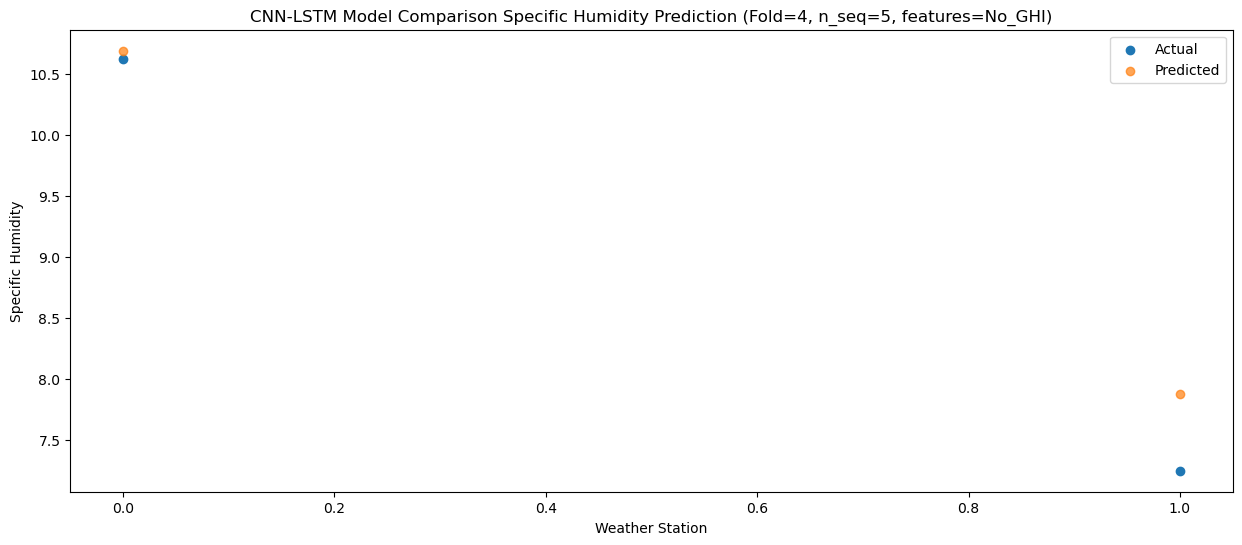

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  10.924021
1                1    7.48   8.079533


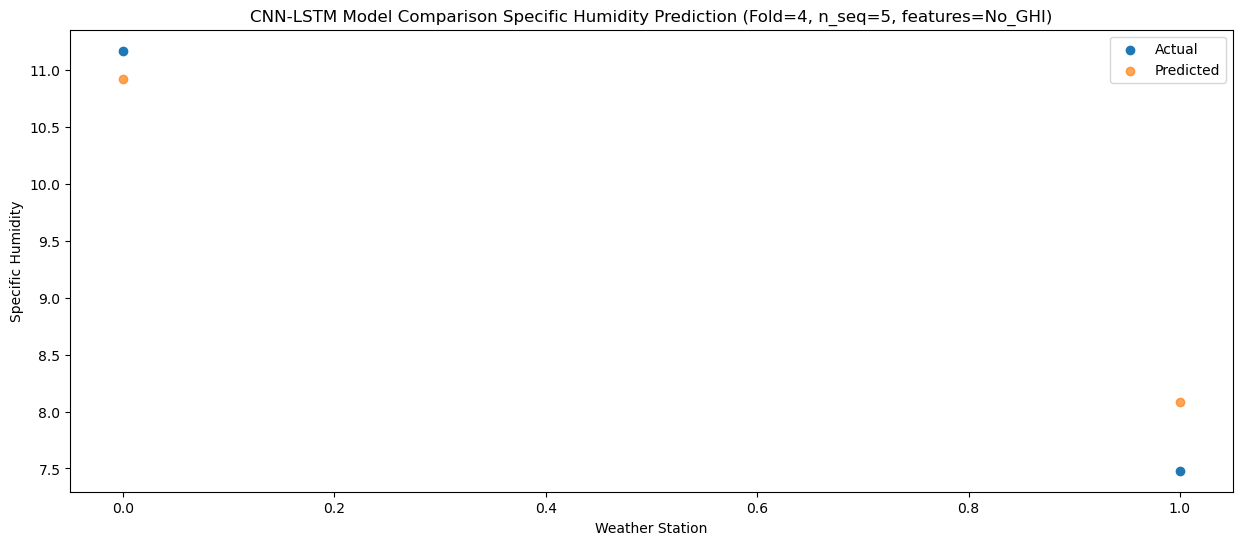

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.89591918  8.06429397]
 [10.7427266   7.98585037]
 [11.07519064  8.21394887]
 [10.68982163  7.87761005]
 [10.92402067  8.07953314]]
Year at t+1:
t+1 SKRMSE: 0.269236
t+1 KRMSE: 0.269236
t+1 MAE: 0.269187
t+1 SKMAPE: 0.029437
t+1 R2_SCORE: 0.974469
t+1 KMAPE: 0.029437
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.398547
t+2 KRMSE: 0.398547
t+2 MAE: 0.391562
t+2 SKMAPE: 0.045317
t+2 R2_SCORE: 0.949300
t+2 KMAPE: 0.045317
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.349683
t+3 KRMSE: 0.349683
t+3 MAE: 0.349379
t+3 SKMAPE: 0.037853
t+3 R2_SCORE: 0.961407
t+3 KMAPE: 0.037853
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.446525
t+4 KRMSE: 0.446525
t+4 MAE: 0.348716
t+4 SKMAPE: 0.046571
t+4 R2_SCORE: 0.929775
t+4 KMAPE: 0.046571
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.458228


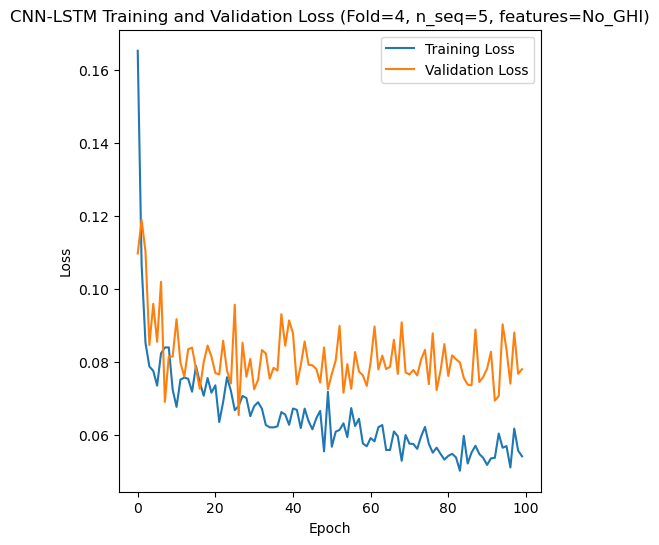

[[0.4556036792363446], [0.5650044169395122], [0.4165543572902064], [0.3721803022808258], [0.39063105204262744]]
[[array(0.45560368)], [array(0.56500442)], [array(0.41655436)], [array(0.3721803)], [array(0.39063105)]]
[[0.38206266766786606], [0.5153341837227347], [0.36249574652314187], [0.2919448370933534], [0.35632009571790724]]
[[0.032609167157064044], [0.06089103127044494], [0.04308139715385308], [0.05247486896700149], [0.04205297210986452]]
[[0.9153531571353853], [0.9011923920457573], [0.5675295282000649], [0.9538454898447257], [0.9512559798740932]]
[[array(0.03260917)], [array(0.06089103)], [array(0.0430814)], [array(0.05247487)], [array(0.04205297)]]
[[array(0.98449136)], [array(0.97482903)], [array(0.82567258)], [array(0.97678952)], [array(0.99500896)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  8.09

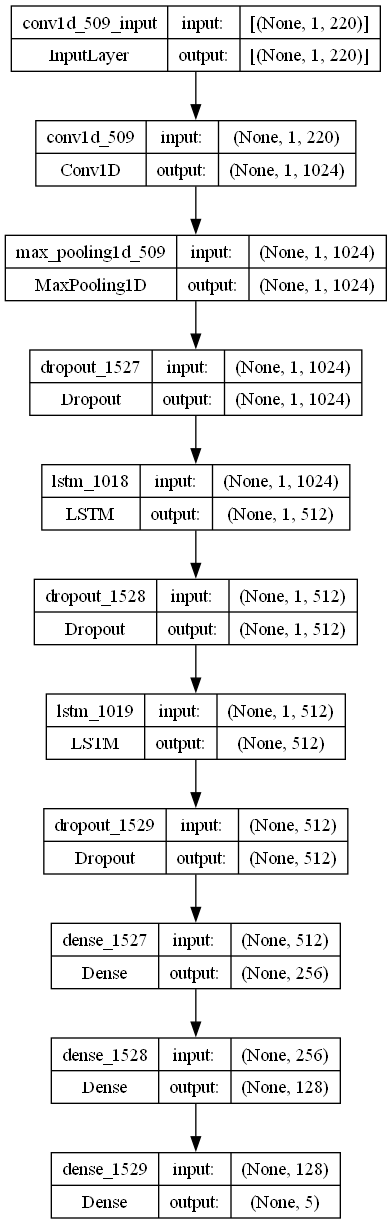

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.001003509572168431
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 512
    dropout_rate = 0.13700828044399488

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

   
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_SH_S5_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)